# Direction

In [ ]:
#direction
import os

import os

current_directory = os.getcwd()
print("Current Directory:", current_directory)


#new_directory = r"D:\My papers\Application"  # Use the 'r' prefix to handle backslashes in Windows paths

new_directory = r"D:\My papers\Application\JobInja"  # Use the 'r' prefix to handle backslashes in Windows paths

# Change the current working directory
os.chdir(new_directory)

# Verify that the directory has been changed
current_directory = os.getcwd()
print("Current Directory:", current_directory)
#D:\My papers\Application\Other

# Tasks

- Read codes
- See dataset and story telling

# JobInja API Dataset

# Trash code

In [3]:
import requests
from bs4 import BeautifulSoup
import json
import csv
import time
from typing import Dict, List, Optional
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

class JobinjaScraper:
    def __init__(self, save_dir: str = "output", delay: float = 1.0, max_workers: int = 5):
        """
        Initialize the scraper
        
        Args:
            save_dir: Directory to save output files
            delay: Time to wait between requests (seconds)
            max_workers: Maximum number of concurrent threads
        """
        self.save_dir = Path(save_dir)
        self.delay = delay
        self.max_workers = max_workers
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        # Create save directory if it doesn't exist
        self.save_dir.mkdir(parents=True, exist_ok=True)

    def get_page_content(self, url: str) -> Optional[str]:
        """Fetch the page content from the given URL"""
        try:
            response = requests.get(url, headers=self.headers)
            response.raise_for_status()
            return response.text
        except requests.RequestException as e:
            print(f"Error fetching page {url}: {e}")
            return None

    def extract_job_info(self, html_content: str, url: str) -> Dict:
        """Extract job information from HTML content"""
        soup = BeautifulSoup(html_content, 'html.parser')
        job_info = {'url': url}  # Include URL in the results

        # Extract job title
        title_div = soup.select_one('div.c-jobView__titleText h1')
        if title_div:
            job_info['عنوان شغلی'] = title_div.text.strip()

        # Extract information from the first info box
        info_box = soup.select_one('ul.c-jobView__firstInfoBox')
        if info_box:
            info_items = info_box.select('li.c-infoBox__item')
            for item in info_items:
                title = item.select_one('h4.c-infoBox__itemTitle')
                value = item.select_one('div.tags span.black')
                if title and value:
                    key = title.text.strip()
                    job_info[key] = value.text.strip()

        # Extract bottom info box information
        bottom_info_box = soup.select('ul.c-infoBox.u-mB0 li.c-infoBox__item')
        for item in bottom_info_box:
            title = item.select_one('h4.c-infoBox__itemTitle')
            values = item.select('div.tags span.black')
            if title and values:
                key = title.text.strip()
                if len(values) > 1:
                    job_info[key] = ', '.join(val.text.strip() for val in values)
                else:
                    job_info[key] = values[0].text.strip()

        return job_info

    def scrape_job(self, url: str) -> Optional[Dict]:
        """Scrape a single job posting"""
        html_content = self.get_page_content(url)
        if html_content:
            job_info = self.extract_job_info(html_content, url)
            time.sleep(self.delay)  # Respect the site by waiting between requests
            return job_info
        return None

    def scrape_jobs(self, urls: List[str], batch_size: int = 100) -> List[Dict]:
        """
        Scrape multiple job postings concurrently with batch processing
        
        Args:
            urls: List of job posting URLs
            batch_size: Number of URLs to process in each batch
        Returns:
            List of dictionaries containing job information
        """
        all_results = []
        total_batches = (len(urls) + batch_size - 1) // batch_size

        for batch_num in range(total_batches):
            start_idx = batch_num * batch_size
            end_idx = min((batch_num + 1) * batch_size, len(urls))
            batch_urls = urls[start_idx:end_idx]

            print(f"Processing batch {batch_num + 1}/{total_batches} ({len(batch_urls)} URLs)")

            with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
                futures = [executor.submit(self.scrape_job, url) for url in batch_urls]
                batch_results = []
                for future in futures:
                    result = future.result()
                    if result:
                        batch_results.append(result)

            # Save batch results
            if batch_results:
                batch_filename = f"batch_{batch_num + 1}"
                self.save_batch(batch_results, batch_filename)
                all_results.extend(batch_results)

        return all_results

    def save_batch(self, data: List[Dict], filename_prefix: str):
        """Save batch results to both JSON and CSV"""
        # Save to JSON
        json_path = self.save_dir / f"{filename_prefix}.json"
        self.save_to_json(data, json_path)

        # Save to CSV
        csv_path = self.save_dir / f"{filename_prefix}.csv"
        self.save_to_csv(data, csv_path)

    def save_to_json(self, data: List[Dict], filepath: Path):
        """Save results to JSON file"""
        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=2)
        print(f"Saved JSON data to {filepath}")

    def save_to_csv(self, data: List[Dict], filepath: Path):
        """Save results to CSV file"""
        if not data:
            print("No data to save")
            return

        # Get all unique keys from all dictionaries
        fieldnames = set()
        for item in data:
            fieldnames.update(item.keys())
        fieldnames = sorted(list(fieldnames))

        with open(filepath, 'w', encoding='utf-8', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(data)
        print(f"Saved CSV data to {filepath}")

def main():
    # Example usage with custom save directory
    save_dir = "JobInja/v9"  # You can change this to your preferred directory
    
    # Load URLs from file
    urls_file = "urls.txt"  # Create this file with your URLs
    try:
        with open(urls_file, 'r', encoding='utf-8') as f:
            urls = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"URLs file {urls_file} not found. Using example URL...")
        urls = [
            "https://jobinja.ir/companies/khanoumi/jobs/Av6Y/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D8%AA%D9%88%D9%84%DB%8C%D8%AF-%D9%85%D8%AD%D8%AA%D9%88%D8%A7-%D9%87%DB%8C%D8%A8%D8%B1%DB%8C%D8%AF-%D8%AF%D8%B1-%D8%AE%D8%A7%D9%86%D9%88%D9%85%DB%8C"
        ]
    
    # Initialize scraper with custom save directory
    scraper = JobinjaScraper(
        save_dir=save_dir,
        delay=1.0,  # 1 second delay between requests
        max_workers=5  # 5 concurrent threads
    )
    
    # Scrape all jobs
    results = scraper.scrape_jobs(urls, batch_size=100)
    
    # Save final combined results
    scraper.save_to_json(results, Path(save_dir) / "all_jobs.json")
    scraper.save_to_csv(results, Path(save_dir) / "all_jobs.csv")
    
    print(f"\nScraping completed:")
    print(f"Total jobs scraped: {len(results)}")
    print(f"Results saved in: {save_dir}")

if __name__ == "__main__":
    main()

URLs file urls.txt not found. Using example URL...
Processing batch 1/1 (1 URLs)
Saved JSON data to JobInja\v9\batch_1.json
Saved CSV data to JobInja\v9\batch_1.csv
Saved JSON data to JobInja\v9\all_jobs.json
Saved CSV data to JobInja\v9\all_jobs.csv

Scraping completed:
Total jobs scraped: 1
Results saved in: JobInja/v9


In [6]:
import requests
from bs4 import BeautifulSoup
from typing import List
import json
import os
from pathlib import Path
from datetime import datetime

class JobinjaURLExtractor:
    def __init__(self, base_url: str = "https://jobinja.ir/jobs", save_dir: str = "jobinja_data"):
        """
        Initialize the URL extractor
        
        Args:
            base_url: Base URL to scrape from
            save_dir: Directory to save output files
        """
        self.base_url = base_url
        self.save_dir = Path(save_dir)
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        # Create save directory if it doesn't exist
        self.save_dir.mkdir(parents=True, exist_ok=True)

    def extract_job_urls_from_html(self, html_content: str) -> List[str]:
        """Extract job URLs from HTML content"""
        soup = BeautifulSoup(html_content, 'html.parser')
        job_links = soup.find_all('a', class_='o-listView__itemIndicator')
        
        urls = []
        for link in job_links:
            href = link.get('href')
            if href and href.startswith('https://jobinja.ir/companies/'):
                clean_url = href.split('?')[0] if '?' in href else href
                urls.append(clean_url)
        
        return urls

    def get_page_content(self, page: int = 1) -> str:
        """Fetch page content from jobinja"""
        url = f"{self.base_url}?page={page}"
        try:
            response = requests.get(url, headers=self.headers)
            response.raise_for_status()
            return response.text
        except requests.RequestException as e:
            print(f"Error fetching page {page}: {e}")
            return None

    def extract_urls_from_pages(self, start_page: int = 1, end_page: int = 1) -> List[str]:
        """Extract job URLs from multiple pages"""
        all_urls = []
        
        for page in range(start_page, end_page + 1):
            print(f"Processing page {page}...")
            html_content = self.get_page_content(page)
            
            if html_content:
                urls = self.extract_job_urls_from_html(html_content)
                all_urls.extend(urls)
                print(f"Found {len(urls)} URLs on page {page}")
            else:
                print(f"Failed to fetch page {page}")
            
            # Save intermediate results for each page
            self.save_urls_to_file(urls, f"page_{page}_urls.json")
        
        return all_urls

    def save_urls_to_file(self, urls: List[str], filename: str):
        """
        Save extracted URLs to a file in the specified directory
        
        Args:
            urls: List of URLs to save
            filename: Name of the file to save
        """
        file_path = self.save_dir / filename
        try:
            with open(file_path, 'w', encoding='utf-8') as f:
                json.dump(urls, f, indent=2, ensure_ascii=False)
            print(f"Successfully saved {len(urls)} URLs to {file_path}")
        except Exception as e:
            print(f"Error saving URLs to file: {e}")

    def save_urls_to_text(self, urls: List[str], filename: str):
        """
        Save URLs to a plain text file (one URL per line)
        
        Args:
            urls: List of URLs to save
            filename: Name of the file to save
        """
        file_path = self.save_dir / filename
        try:
            with open(file_path, 'w', encoding='utf-8') as f:
                for url in urls:
                    f.write(f"{url}\n")
            print(f"Successfully saved {len(urls)} URLs to {file_path}")
        except Exception as e:
            print(f"Error saving URLs to text file: {e}")

    def print_urls(self, urls: List[str], max_display: int = None):
        """
        Print URLs to console
        
        Args:
            urls: List of URLs to print
            max_display: Maximum number of URLs to display (None for all)
        """
        if not urls:
            print("No URLs found.")
            return

        print("\nExtracted URLs:")
        print("-" * 80)
        
        display_urls = urls[:max_display] if max_display else urls
        for i, url in enumerate(display_urls, 1):
            print(f"{i}. {url}")
        
        if max_display and len(urls) > max_display:
            print(f"\n... and {len(urls) - max_display} more URLs")
        
        print("-" * 80)
        print(f"Total URLs: {len(urls)}")

def main():
    # Example usage
    save_dir = "JobInja/urls"  # Specify save directory
    
    # Initialize extractor with save directory
    extractor = JobinjaURLExtractor(save_dir=save_dir)
    
    # Extract URLs from first 3 pages
    urls = extractor.extract_urls_from_pages(start_page=1, end_page=3)
    
    # Save URLs in different formats
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save as JSON
    extractor.save_urls_to_file(urls, f"all_urls_{timestamp}.json")
    
    # Save as text file
    extractor.save_urls_to_text(urls, f"all_urls_{timestamp}.txt")
    
    # Print URLs to console (display first 10)
    extractor.print_urls(urls, max_display=10)
    
    # Print summary
    print(f"\nFiles saved in: {save_dir}")
    print(f"Total URLs extracted: {len(urls)}")

if __name__ == "__main__":
    main()

Processing page 1...
Found 20 URLs on page 1
Successfully saved 20 URLs to JobInja\urls\page_1_urls.json
Processing page 2...
Found 20 URLs on page 2
Successfully saved 20 URLs to JobInja\urls\page_2_urls.json
Processing page 3...
Found 20 URLs on page 3
Successfully saved 20 URLs to JobInja\urls\page_3_urls.json
Successfully saved 60 URLs to JobInja\urls\all_urls_20241107_194707.json
Successfully saved 60 URLs to JobInja\urls\all_urls_20241107_194707.txt

Extracted URLs:
--------------------------------------------------------------------------------
1. https://jobinja.ir/companies/pishro-sanat-arshit-1/jobs/Apb6/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D9%85%D8%B3%D8%A6%D9%88%D9%84-%D8%AF%D9%81%D8%AA%D8%B1-%D9%85%D8%B3%D9%84%D8%B7-%D8%A8%D9%87-%D8%A7%D9%86%DA%AF%D9%84%DB%8C%D8%B3%DB%8C-%D8%AE%D8%A7%D9%86%D9%85-%D8%AF%D8%B1-%D8%B4%D8%B1%DA%A9%D8%AA-%D9%BE%DB%8C%D8%B4%D8%B1%D9%88%D8%B5%D9%86%D8%B9%D8%AA-%D8%A2%D8%B1%D8%B4%DB%8C%D8%AA
2. https://jobinja.ir/companies/verge/jobs/ApET/%

In [8]:
import requests
from bs4 import BeautifulSoup
from typing import List, Dict
import json
import os
from pathlib import Path
from datetime import datetime
import time
from tqdm import tqdm

class JobinjaPaginatedURLExtractor:
    def __init__(self, save_dir: str = "jobinja_data", delay: float = 1.0):
        """
        Initialize the URL extractor
        
        Args:
            save_dir: Directory to save output files
            delay: Delay between requests in seconds
        """
        self.base_url = "https://jobinja.ir/jobs"
        self.save_dir = Path(save_dir)
        self.delay = delay
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        # Create save directory if it doesn't exist
        self.save_dir.mkdir(parents=True, exist_ok=True)

    def get_page_url(self, page: int) -> str:
        """Generate URL for specific page"""
        return f"{self.base_url}?page={page}"

    def extract_urls_from_html(self, html_content: str) -> List[str]:
        """Extract job URLs from HTML content"""
        soup = BeautifulSoup(html_content, 'html.parser')
        job_links = soup.find_all('a', class_='o-listView__itemIndicator')
        
        urls = []
        for link in job_links:
            href = link.get('href')
            if href and href.startswith('https://jobinja.ir/companies/'):
                # Clean up URL by removing tracking parameters
                clean_url = href.split('?')[0] if '?' in href else href
                urls.append(clean_url)
        
        return urls

    def get_page_content(self, page: int) -> str:
        """Fetch page content with retry mechanism"""
        url = self.get_page_url(page)
        max_retries = 3
        
        for attempt in range(max_retries):
            try:
                response = requests.get(url, headers=self.headers)
                response.raise_for_status()
                return response.text
            except requests.RequestException as e:
                if attempt == max_retries - 1:
                    print(f"Error fetching page {page} after {max_retries} attempts: {e}")
                    return None
                time.sleep(self.delay * 2)  # Wait longer between retries
        
        return None

    def scrape_all_pages(self, start_page: int = 1, end_page: int = 30) -> Dict[int, List[str]]:
        """
        Scrape URLs from all pages in range
        
        Args:
            start_page: First page to scrape
            end_page: Last page to scrape
            
        Returns:
            Dictionary mapping page numbers to lists of URLs
        """
        results = {}
        
        # Create progress bar
        with tqdm(total=end_page - start_page + 1, desc="Scraping pages") as pbar:
            for page in range(start_page, end_page + 1):
                # Fetch and process page
                html_content = self.get_page_content(page)
                
                if html_content:
                    urls = self.extract_urls_from_html(html_content)
                    results[page] = urls
                    
                    # Save intermediate results
                    self.save_page_results(page, urls)
                else:
                    results[page] = []
                    print(f"\nFailed to fetch page {page}")
                
                # Update progress bar
                pbar.update(1)
                pbar.set_postfix({'URLs': len(results[page])})
                
                # Respect the site by waiting between requests
                time.sleep(self.delay)
        
        return results

    def save_page_results(self, page: int, urls: List[str]):
        """Save results for individual page"""
        filename = f"page_{page:03d}_urls.json"
        file_path = self.save_dir / filename
        
        with open(file_path, 'w', encoding='utf-8') as f:
            json.dump({
                'page': page,
                'urls': urls,
                'count': len(urls),
                'timestamp': datetime.now().isoformat()
            }, f, indent=2, ensure_ascii=False)

    def save_combined_results(self, results: Dict[int, List[str]], format: str = 'both'):
        """
        Save combined results in specified format
        
        Args:
            results: Dictionary of results by page
            format: Output format ('json', 'txt', or 'both')
        """
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Flatten URLs into a single list
        all_urls = []
        for page_urls in results.values():
            all_urls.extend(page_urls)
        
        # Save as JSON if requested
        if format in ['json', 'both']:
            json_path = self.save_dir / f"all_urls_{timestamp}.json"
            with open(json_path, 'w', encoding='utf-8') as f:
                json.dump({
                    'total_urls': len(all_urls),
                    'total_pages': len(results),
                    'urls_by_page': results,
                    'timestamp': datetime.now().isoformat()
                }, f, indent=2, ensure_ascii=False)
            print(f"\nSaved JSON results to: {json_path}")
        
        # Save as text if requested
        if format in ['txt', 'both']:
            txt_path = self.save_dir / f"all_urls_{timestamp}.txt"
            with open(txt_path, 'w', encoding='utf-8') as f:
                for url in all_urls:
                    f.write(f"{url}\n")
            print(f"Saved text results to: {txt_path}")
        
        return all_urls

    def print_summary(self, results: Dict[int, List[str]], max_display: int = 10):
        """Print summary of results"""
        total_urls = sum(len(urls) for urls in results.values())
        
        print("\nScraping Summary")
        print("-" * 50)
        print(f"Total pages scraped: {len(results)}")
        print(f"Total URLs found: {total_urls}")
        print(f"Average URLs per page: {total_urls / len(results):.1f}")
        
        # Print sample URLs
        print(f"\nSample URLs (first {max_display}):")
        urls_shown = 0
        for page, page_urls in sorted(results.items()):
            for url in page_urls:
                if urls_shown >= max_display:
                    break
                print(f"{urls_shown + 1}. {url}")
                urls_shown += 1
            if urls_shown >= max_display:
                break

def main():
    # Initialize extractor
    save_dir = "JobInja/urls2"  # Specify save directory
    extractor = JobinjaPaginatedURLExtractor(save_dir=save_dir, delay=1.0)
    
    # Scrape pages 1 to 30
    print(f"Starting URL extraction (saving to {save_dir})...")
    results = extractor.scrape_all_pages(start_page=1, end_page=30)
    
    # Save combined results
    all_urls = extractor.save_combined_results(results, format='both')
    
    # Print summary
    extractor.print_summary(results)
    
    return all_urls

if __name__ == "__main__":
    urls = main()

Starting URL extraction (saving to JobInja/urls2)...


Scraping pages: 100%|██████████| 30/30 [01:00<00:00,  2.01s/it, URLs=20]


Saved JSON results to: JobInja\urls2\all_urls_20241107_195433.json
Saved text results to: JobInja\urls2\all_urls_20241107_195433.txt

Scraping Summary
--------------------------------------------------
Total pages scraped: 30
Total URLs found: 600
Average URLs per page: 20.0

Sample URLs (first 10):
1. https://jobinja.ir/companies/pishro-sanat-arshit-1/jobs/Apb6/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D9%85%D8%B3%D8%A6%D9%88%D9%84-%D8%AF%D9%81%D8%AA%D8%B1-%D9%85%D8%B3%D9%84%D8%B7-%D8%A8%D9%87-%D8%A7%D9%86%DA%AF%D9%84%DB%8C%D8%B3%DB%8C-%D8%AE%D8%A7%D9%86%D9%85-%D8%AF%D8%B1-%D8%B4%D8%B1%DA%A9%D8%AA-%D9%BE%DB%8C%D8%B4%D8%B1%D9%88%D8%B5%D9%86%D8%B9%D8%AA-%D8%A2%D8%B1%D8%B4%DB%8C%D8%AA
2. https://jobinja.ir/companies/verge/jobs/ApET/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-senior-front-end-developer-%D8%AF%D8%B1-%DA%A9%D9%84%D8%A7%D8%AF%DB%8C%D9%86%D8%A7%D8%AA%D9%88%D8%B1
3. https://jobinja.ir/companies/aiwaweb/jobs/A6Xo/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D

In [9]:
import requests
from bs4 import BeautifulSoup
from typing import Dict, List, Optional
import json
import time
from pathlib import Path
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

class JobinjaPageScraper:
    def __init__(self, save_dir: str = "jobinja_data", delay: float = 1.0, max_workers: int = 5):
        """
        Initialize the scraper
        
        Args:
            save_dir: Directory to save output files
            delay: Time to wait between requests (seconds)
            max_workers: Maximum number of concurrent threads
        """
        self.base_url = "https://jobinja.ir/jobs"
        self.save_dir = Path(save_dir)
        self.delay = delay
        self.max_workers = max_workers
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        # Create save directory and subdirectories
        self.save_dir.mkdir(parents=True, exist_ok=True)
        self.pages_dir = self.save_dir / "pages"
        self.pages_dir.mkdir(exist_ok=True)

    def get_page_content(self, page: int) -> Optional[str]:
        """Fetch content for a specific page"""
        url = f"{self.base_url}?page={page}"
        try:
            response = requests.get(url, headers=self.headers)
            response.raise_for_status()
            return response.text
        except requests.RequestException as e:
            print(f"Error fetching page {page}: {e}")
            return None

    def extract_page_urls(self, html_content: str) -> List[str]:
        """Extract job URLs from a page"""
        soup = BeautifulSoup(html_content, 'html.parser')
        job_links = soup.find_all('a', class_='o-listView__itemIndicator')
        
        urls = []
        for link in job_links:
            href = link.get('href')
            if href and href.startswith('https://jobinja.ir/companies/'):
                clean_url = href.split('?')[0]
                urls.append(clean_url)
        
        return urls

    def scrape_page(self, page: int) -> Dict:
        """Scrape a single page"""
        print(f"Scraping page {page}...")
        
        html_content = self.get_page_content(page)
        if not html_content:
            return {
                'page': page,
                'urls': [],
                'timestamp': datetime.now().isoformat(),
                'status': 'failed'
            }
        
        urls = self.extract_page_urls(html_content)
        
        result = {
            'page': page,
            'urls': urls,
            'count': len(urls),
            'timestamp': datetime.now().isoformat(),
            'status': 'success'
        }
        
        # Save page results immediately
        self.save_page_results(page, result)
        
        return result

    def scrape_pages(self, start_page: int = 1, end_page: int = 30) -> Dict[int, List[str]]:
        """
        Scrape multiple pages
        
        Args:
            start_page: First page to scrape
            end_page: Last page to scrape
        Returns:
            Dictionary mapping page numbers to lists of URLs
        """
        results = {}
        
        # Create progress bar
        with tqdm(total=end_page - start_page + 1, desc="Scraping pages") as pbar:
            for page in range(start_page, end_page + 1):
                result = self.scrape_page(page)
                results[page] = result['urls']
                
                # Update progress
                pbar.update(1)
                pbar.set_postfix({'URLs': len(result['urls'])})
                
                # Wait between requests
                time.sleep(self.delay)
        
        # Save combined results
        self.save_combined_results(results)
        
        return results

    def save_page_results(self, page: int, data: Dict):
        """Save results for a single page"""
        filename = f"page_{page:03d}.json"
        filepath = self.pages_dir / filename
        
        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=2)
        print(f"Saved page {page} results to {filepath}")

    def save_combined_results(self, results: Dict[int, List[str]]):
        """Save combined results from all pages"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filepath = self.save_dir / f"all_pages_{timestamp}.json"
        
        # Calculate total URLs
        total_urls = sum(len(urls) for urls in results.values())
        
        data = {
            'total_urls': total_urls,
            'total_pages': len(results),
            'urls_by_page': results,
            'timestamp': datetime.now().isoformat()
        }
        
        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=2)
        print(f"\nSaved combined results to {filepath}")

    def print_summary(self, results: Dict[int, List[str]]):
        """Print summary of results"""
        total_urls = sum(len(urls) for urls in results.values())
        
        print("\nScraping Summary")
        print("-" * 50)
        print(f"Total pages scraped: {len(results)}")
        print(f"Total URLs found: {total_urls}")
        print(f"Average URLs per page: {total_urls / len(results):.1f}")
        print(f"\nResults saved in: {self.save_dir}")
        print(f"Individual pages saved in: {self.pages_dir}")

def main():
    # Initialize scraper with custom save directory
    save_dir = "JobInja/v12"  # You can change this to your preferred directory
    scraper = JobinjaPageScraper(
        save_dir=save_dir,
        delay=1.0,  # 1 second delay between requests
        max_workers=5  # 5 concurrent threads
    )
    
    # Scrape pages 1-30
    results = scraper.scrape_pages(start_page=1, end_page=30)
    
    # Print summary
    scraper.print_summary(results)
    
    print("\nExample URLs from first page:")
    if 1 in results and results[1]:
        for i, url in enumerate(results[1][:5], 1):
            print(f"{i}. {url}")

if __name__ == "__main__":
    main()

Scraping pages:   0%|          | 0/30 [00:00<?, ?it/s]

Scraping page 1...


Scraping pages:   3%|▎         | 1/30 [00:03<01:32,  3.20s/it, URLs=20]

Saved page 1 results to JobInja\v12\pages\page_001.json
Scraping page 2...


Scraping pages:   7%|▋         | 2/30 [00:05<01:13,  2.64s/it, URLs=20]

Saved page 2 results to JobInja\v12\pages\page_002.json
Scraping page 3...


Scraping pages:  10%|█         | 3/30 [00:07<01:09,  2.57s/it, URLs=20]

Saved page 3 results to JobInja\v12\pages\page_003.json
Scraping page 4...


Scraping pages:  13%|█▎        | 4/30 [00:10<01:04,  2.49s/it, URLs=20]

Saved page 4 results to JobInja\v12\pages\page_004.json
Scraping page 5...


Scraping pages:  17%|█▋        | 5/30 [00:12<01:01,  2.46s/it, URLs=20]

Saved page 5 results to JobInja\v12\pages\page_005.json
Scraping page 6...


Scraping pages:  20%|██        | 6/30 [00:15<00:58,  2.45s/it, URLs=20]

Saved page 6 results to JobInja\v12\pages\page_006.json
Scraping page 7...


Scraping pages:  23%|██▎       | 7/30 [00:17<00:53,  2.32s/it, URLs=20]

Saved page 7 results to JobInja\v12\pages\page_007.json
Scraping page 8...


Scraping pages:  27%|██▋       | 8/30 [00:19<00:51,  2.33s/it, URLs=20]

Saved page 8 results to JobInja\v12\pages\page_008.json
Scraping page 9...


Scraping pages:  30%|███       | 9/30 [00:22<00:50,  2.39s/it, URLs=20]

Saved page 9 results to JobInja\v12\pages\page_009.json
Scraping page 10...


Scraping pages:  33%|███▎      | 10/30 [00:24<00:49,  2.47s/it, URLs=20]

Saved page 10 results to JobInja\v12\pages\page_010.json
Scraping page 11...


Scraping pages:  37%|███▋      | 11/30 [00:27<00:45,  2.41s/it, URLs=20]

Saved page 11 results to JobInja\v12\pages\page_011.json
Scraping page 12...


Scraping pages:  40%|████      | 12/30 [00:29<00:43,  2.43s/it, URLs=20]

Saved page 12 results to JobInja\v12\pages\page_012.json
Scraping page 13...


Scraping pages:  43%|████▎     | 13/30 [00:31<00:40,  2.39s/it, URLs=20]

Saved page 13 results to JobInja\v12\pages\page_013.json
Scraping page 14...


Scraping pages:  47%|████▋     | 14/30 [00:34<00:38,  2.41s/it, URLs=20]

Saved page 14 results to JobInja\v12\pages\page_014.json
Scraping page 15...


Scraping pages:  50%|█████     | 15/30 [00:36<00:37,  2.52s/it, URLs=20]

Saved page 15 results to JobInja\v12\pages\page_015.json
Scraping page 16...


Scraping pages:  53%|█████▎    | 16/30 [00:44<00:55,  3.99s/it, URLs=20]

Saved page 16 results to JobInja\v12\pages\page_016.json
Scraping page 17...


Scraping pages:  57%|█████▋    | 17/30 [00:49<00:57,  4.45s/it, URLs=20]

Saved page 17 results to JobInja\v12\pages\page_017.json
Scraping page 18...


Scraping pages:  60%|██████    | 18/30 [00:52<00:48,  4.02s/it, URLs=20]

Saved page 18 results to JobInja\v12\pages\page_018.json
Scraping page 19...


Scraping pages:  63%|██████▎   | 19/30 [00:55<00:38,  3.55s/it, URLs=20]

Saved page 19 results to JobInja\v12\pages\page_019.json
Scraping page 20...


Scraping pages:  67%|██████▋   | 20/30 [00:58<00:33,  3.38s/it, URLs=20]

Saved page 20 results to JobInja\v12\pages\page_020.json
Scraping page 21...


Scraping pages:  70%|███████   | 21/30 [01:04<00:38,  4.25s/it, URLs=20]

Saved page 21 results to JobInja\v12\pages\page_021.json
Scraping page 22...


Scraping pages:  73%|███████▎  | 22/30 [01:33<01:32, 11.60s/it, URLs=20]

Saved page 22 results to JobInja\v12\pages\page_022.json
Scraping page 23...


Scraping pages:  77%|███████▋  | 23/30 [03:13<04:26, 38.07s/it, URLs=0] 

Error fetching page 23: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Scraping page 24...


Scraping pages:  80%|████████  | 24/30 [03:25<03:01, 30.32s/it, URLs=0]

Error fetching page 24: HTTPSConnectionPool(host='jobinja.ir', port=443): Max retries exceeded with url: /jobs?page=24 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000026D1BD0EA50>: Failed to resolve 'jobinja.ir' ([Errno 11001] getaddrinfo failed)"))
Scraping page 25...


Scraping pages:  83%|████████▎ | 25/30 [03:32<01:56, 23.22s/it, URLs=20]

Saved page 25 results to JobInja\v12\pages\page_025.json
Scraping page 26...


Scraping pages:  87%|████████▋ | 26/30 [03:33<01:07, 16.81s/it, URLs=20]

Saved page 26 results to JobInja\v12\pages\page_026.json
Scraping page 27...


Scraping pages:  90%|█████████ | 27/30 [03:35<00:36, 12.31s/it, URLs=20]

Saved page 27 results to JobInja\v12\pages\page_027.json
Scraping page 28...


Scraping pages:  93%|█████████▎| 28/30 [03:37<00:18,  9.18s/it, URLs=20]

Saved page 28 results to JobInja\v12\pages\page_028.json
Scraping page 29...


Scraping pages:  97%|█████████▋| 29/30 [03:39<00:07,  7.03s/it, URLs=20]

Saved page 29 results to JobInja\v12\pages\page_029.json
Scraping page 30...


Scraping pages: 100%|██████████| 30/30 [03:41<00:00,  5.49s/it, URLs=20]

Saved page 30 results to JobInja\v12\pages\page_030.json


Scraping pages: 100%|██████████| 30/30 [03:42<00:00,  7.42s/it, URLs=20]


Saved combined results to JobInja\v12\all_pages_20241107_230935.json

Scraping Summary
--------------------------------------------------
Total pages scraped: 30
Total URLs found: 560
Average URLs per page: 18.7

Results saved in: JobInja\v12
Individual pages saved in: JobInja\v12\pages

Example URLs from first page:
1. https://jobinja.ir/companies/pishro-sanat-arshit-1/jobs/Apb6/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D9%85%D8%B3%D8%A6%D9%88%D9%84-%D8%AF%D9%81%D8%AA%D8%B1-%D9%85%D8%B3%D9%84%D8%B7-%D8%A8%D9%87-%D8%A7%D9%86%DA%AF%D9%84%DB%8C%D8%B3%DB%8C-%D8%AE%D8%A7%D9%86%D9%85-%D8%AF%D8%B1-%D8%B4%D8%B1%DA%A9%D8%AA-%D9%BE%DB%8C%D8%B4%D8%B1%D9%88%D8%B5%D9%86%D8%B9%D8%AA-%D8%A2%D8%B1%D8%B4%DB%8C%D8%AA
2. https://jobinja.ir/companies/verge/jobs/ApET/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-senior-front-end-developer-%D8%AF%D8%B1-%DA%A9%D9%84%D8%A7%D8%AF%DB%8C%D9%86%D8%A7%D8%AA%D9%88%D8%B1
3. https://jobinja.ir/companies/aiwaweb/jobs/A6Xo/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D

In [18]:
import json
from pathlib import Path
from typing import List, Dict, Optional
import time
import os
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from hazm import Normalizer, word_tokenize
import arabic_reshaper
from bidi.algorithm import get_display
import base64
from io import BytesIO
import matplotlib.font_manager as fm

class JobinjaDataProcessor:
    def __init__(self, save_dir: str = "jobinja_data"):
        """
        Initialize the processor
        """
        self.save_dir = Path(save_dir.strip().replace('\x0b', '').replace('\x07', ''))
        self.save_dir.mkdir(parents=True, exist_ok=True)
        
        # Create directory for word clouds
        self.wordcloud_dir = self.save_dir / "wordclouds"
        self.wordcloud_dir.mkdir(parents=True, exist_ok=True)
        
        # Initialize Persian text processor
        self.normalizer = Normalizer()
        
        # Get available fonts
        self.font_path = self.get_persian_font()
        if not self.font_path:
            print("Warning: No suitable Persian font found. Word clouds may not render correctly.")
        
        # Persian stopwords
        self.stopwords = set([
            'و', 'در', 'به', 'از', 'که', 'می', 'این', 'است', 'را', 'با', 'های', 'برای',
            'آن', 'خود', 'تا', 'کرد', 'بر', 'هر', 'نیز', 'ما', 'اما', 'یا', 'شد', 'او',
            'ها', 'هم', 'شده', 'کند', 'من', 'باید', 'دارد', 'دیگر', 'همه', 'شود', 'یک',
            'می‌باشد', 'می‌شود', 'شرکت', 'سال', 'کار', 'فعالیت', 'ایران', 'دارای', 'بوده',
            'توسط', 'بین', 'پس', 'شما', 'گردید', 'باشد', 'توانید', 'بخش', 'زمینه', 'افراد',
            'چند', 'بود', 'جهت', 'دهد', 'شوند', 'بسیار', 'براساس', 'پیش', 'بیش', 'پس'
        ])

    def get_persian_font(self) -> Optional[str]:
        """Find a suitable Persian font"""
        # List of possible Persian fonts
        persian_fonts = [
            'Vazir', 'Iran', 'IRANSans', 'Tahoma', 'Arial', 'B Nazanin', 
            'Times New Roman', 'DejaVu Sans', 'Noto Naskh Arabic'
        ]
        
        # First check if Vazir.ttf exists in current directory
        if os.path.exists('Vazir.ttf'):
            return 'Vazir.ttf'
            
        # Then check system fonts
        system_fonts = set([f.name for f in fm.fontManager.ttflist])
        
        for font in persian_fonts:
            if font in system_fonts:
                try:
                    font_path = fm.findfont(font)
                    print(f"Using font: {font}")
                    return font_path
                except:
                    continue
                    
        return None

    def create_circular_mask(self, width, height):
        """Create circular mask for word cloud"""
        center = (int(width/2), int(height/2))
        radius = min(width, height) // 2
        Y, X = np.ogrid[:height, :width]
        dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
        mask = dist_from_center <= radius
        return mask

    def preprocess_persian_text(self, text: str) -> str:
        """Preprocess Persian text for word cloud"""
        if not text:
            return ""
            
        # Normalize text
        text = self.normalizer.normalize(text)
        
        # Remove special characters and extra whitespace
        text = re.sub(r'[^\w\s\u0600-\u06FF]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        
        # Tokenize
        words = word_tokenize(text)
        
        # Remove stopwords and short words
        words = [w for w in words if w not in self.stopwords and len(w) > 1]
        
        return ' '.join(words)

    def generate_wordcloud(self, text: str, job_id: int) -> Optional[str]:
        """Generate word cloud for Persian text"""
        try:
            if not text or not self.font_path:
                return None
                
            # Preprocess text
            processed_text = self.preprocess_persian_text(text)
            if not processed_text:
                return None
                
            # Reshape Persian text
            processed_text = arabic_reshaper.reshape(processed_text)
            processed_text = get_display(processed_text)
            
            # Create word cloud
            mask = self.create_circular_mask(400, 400)
            wordcloud = WordCloud(
                width=400,
                height=400,
                background_color='white',
                mask=mask,
                font_path=self.font_path,
                max_words=100,
                min_font_size=10,
                prefer_horizontal=0.7
            ).generate(processed_text)
            
            # Create figure
            plt.figure(figsize=(10, 10))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            
            # Save to BytesIO
            img_data = BytesIO()
            plt.savefig(img_data, format='png', bbox_inches='tight', pad_inches=0)
            plt.close()
            
            # Convert to base64
            img_data.seek(0)
            img_base64 = base64.b64encode(img_data.read()).decode()
            
            # Save individual word cloud image
            wordcloud_path = self.wordcloud_dir / f"wordcloud_{job_id}.png"
            wordcloud.to_file(str(wordcloud_path))
            
            return img_base64
            
        except Exception as e:
            print(f"Error generating word cloud for job {job_id}: {e}")
            if 'font' in str(e).lower():
                print("Font-related error. Available fonts:", fm.findSystemFonts())
            return None

    def extract_company_name(self, url: str) -> str:
        """Extract company name from job URL"""
        try:
            pattern = r'companies/([^/]+)/jobs'
            match = re.search(pattern, url)
            return match.group(1) if match else "unknown"
        except Exception as e:
            print(f"Error extracting company name from URL {url}: {e}")
            return "unknown"

    def process_job(self, job: Dict, index: int) -> Dict:
        """Process a single job entry"""
        # Extract company name
        company_name = self.extract_company_name(job.get('url', ''))
        
        # Generate word cloud
        company_desc = job.get('معرفی شرکت', '')
        wordcloud_base64 = self.generate_wordcloud(company_desc, index)
        
        # Create processed job dict
        processed_job = {
            'id': index,
            'company_name': company_name,
            'wordcloud': wordcloud_base64 if wordcloud_base64 else None,
            **job
        }
        
        return processed_job

    def process_file(self, input_file: str, output_file: str = None):
        """Process a JSON file"""
        try:
            # Validate input file
            input_path = Path(input_file)
            if not input_path.exists():
                print(f"Error: Input file not found: {input_path}")
                return

            # Set output file
            if output_file is None:
                timestamp = time.strftime("%Y%m%d_%H%M%S")
                output_path = self.save_dir / f"jobs_processed_{timestamp}.json"
            else:
                output_path = Path(output_file)

            print(f"Processing file: {input_path}")
            print(f"Using font: {self.font_path}")

            # Read input file
            with open(input_path, 'r', encoding='utf-8') as f:
                jobs = json.load(f)

            # Process jobs
            processed_jobs = []
            total_jobs = len(jobs)
            
            print(f"\nProcessing {total_jobs} jobs...")
            for i, job in enumerate(jobs, 1):
                print(f"Processing job {i}/{total_jobs}", end='\r')
                processed_job = self.process_job(job, i)
                processed_jobs.append(processed_job)

            # Save processed jobs
            output_path.parent.mkdir(parents=True, exist_ok=True)
            with open(output_path, 'w', encoding='utf-8') as f:
                json.dump(processed_jobs, f, ensure_ascii=False, indent=2)

            print(f"\nSuccessfully processed {len(processed_jobs)} jobs")
            print(f"Word clouds saved in: {self.wordcloud_dir}")
            print(f"Processed file saved to: {output_path}")
            
            # Print sample and stats
            self.print_summary(processed_jobs)

        except Exception as e:
            print(f"\nError processing file: {e}")
            print("Current working directory:", os.getcwd())

    def print_summary(self, jobs: List[Dict]):
        """Print summary of processed jobs"""
        print("\nProcessing Summary:")
        print("-" * 50)
        
        # Count jobs with word clouds
        jobs_with_clouds = sum(1 for job in jobs if job.get('wordcloud'))
        print(f"Total jobs processed: {len(jobs)}")
        print(f"Jobs with word clouds: {jobs_with_clouds}")
        
        # Print sample job
        if jobs:
            print("\nSample processed job:")
            job = jobs[0]
            print(f"ID: {job['id']}")
            print(f"Company: {job['company_name']}")
            print(f"Title: {job.get('عنوان شغلی', 'No title')}")
            print(f"Has word cloud: {'Yes' if job.get('wordcloud') else 'No'}")

def main():
    # Get current directory
    current_dir = Path.cwd()
    
    # Initialize processor
    save_dir = current_dir / "jobinja_processed_data"
    processor = JobinjaDataProcessor(save_dir=str(save_dir))
    
    # Set file paths
    input_file = current_dir / "JobInja" / "v11" / "all_jobs.json"
    output_file = save_dir / "jobs_with_wordclouds.json"
    
    print("Starting job processing...")
    processor.process_file(
        input_file=str(input_file),
        output_file=str(output_file)
    )

if __name__ == "__main__":
    main()

Using font: Vazir
Starting job processing...
Processing file: C:\Users\saeid\JobInja\v11\all_jobs.json
Using font: C:\Users\saeid\AppData\Local\Microsoft\Windows\Fonts\Vazir-Regular.ttf

Processing 60 jobs...
Processing job 60/60
Successfully processed 60 jobs
Word clouds saved in: C:\Users\saeid\jobinja_processed_data\wordclouds
Processed file saved to: C:\Users\saeid\jobinja_processed_data\jobs_with_wordclouds.json

Processing Summary:
--------------------------------------------------
Total jobs processed: 60
Jobs with word clouds: 60

Sample processed job:
ID: 1
Company: pishro-sanat-arshit-1
Title: استخدام مسئول دفتر (مسلط به انگلیسی-خانم)
Has word cloud: Yes


In [23]:
# Install Visual Studio Build Tools (if not already installed)
!pip install --upgrade setuptools wheel
!pip install --upgrade pip

  Obtaining dependency information for setuptools from https://files.pythonhosted.org/packages/90/12/282ee9bce8b58130cb762fbc9beabd531549952cac11fc56add11dcb7ea0/setuptools-75.3.0-py3-none-any.whl.metadata
  Obtaining dependency information for wheel from https://files.pythonhosted.org/packages/1b/d1/9babe2ccaecff775992753d8686970b1e2755d21c8a63be73aba7a4e7d77/wheel-0.44.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.3 MB 656.4 kB/s eta 0:00:02
   -- ------------------------------------- 0.1/1.3 MB 751.6 kB/s eta 0:00:02
   --- ------------------------------------ 0.1/1.3 MB 590.8 kB/s eta 0:00:02
   ----- ----------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.75 requires requests_mock, which is not installed.
conda-repo-cli 1.0.75 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.75 requires PyYAML==6.0.1, but you have pyyaml 6.0 which is incompatible.


  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/ef/7d/500c9ad20238fcfcb4cb9243eede163594d7020ce87bd9610c9e02771876/pip-24.3.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
    --------------------------------------- 0.0/1.8 MB 330.3 kB/s eta 0:00:06
    --------------------------------------- 0.0/1.8 MB 281.8 kB/s eta 0:00:07
   -- ------------------------------------- 0.1/1.8 MB 492.8 kB/s eta 0:00:04
   --- ------------------------------------ 0.2/1.8 MB 573.4 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.8 MB 758.5 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.8 MB 758.5 kB/s eta 0:00:03
   ------- -------------------------------- 0.4/1.8 MB 890.4 kB/s eta 0:00:02
   -------- ------------------------------- 0.4/1.8 MB 

ERROR: To modify pip, please run the following command:
C:\Users\saeid\anaconda3\python.exe -m pip install --upgrade pip


In [ ]:
# Remove existing installations
!pip uninstall wordcloud wordcloud_fa

# Install dependencies first
!pip install numpy matplotlib Pillow

# Install wordcloud from binary
!pip install --no-cache-dir wordcloud-binary

# Now install wordcloud_fa
!pip install wordcloud_fa

In [24]:
!pip install wordcloud_fa

  Obtaining dependency information for wordcloud_fa from https://files.pythonhosted.org/packages/d2/36/16bfbb32ab1fa0cf673f179c5ef38deac9deb74933f9f56322448e7f734b/wordcloud_fa-0.1.10-py3-none-any.whl.metadata
  Using cached wordcloud_fa-0.1.10-py3-none-any.whl.metadata (11 kB)
  Using cached wordcloud-1.8.2.2.tar.gz (220 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [1 lines of output]
  ERROR: Can not execute `setup.py` since setuptools is not available in the build environment.
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

Encountered error while generating package metadata.

See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [25]:
import json
from pathlib import Path
from typing import List, Dict, Optional
import time
import os
import re
from wordcloud_fa import WordCloudFa
import matplotlib.pyplot as plt
import numpy as np
from hazm import Normalizer, word_tokenize
import arabic_reshaper
from bidi.algorithm import get_display
import base64
from io import BytesIO
import math

class JobinjaDataProcessor:
    def __init__(self, save_dir: str = "jobinja_data", font_path: str = 'NotoNaskhArabic-Regular.ttf'):
        """Initialize the processor"""
        self.save_dir = Path(save_dir.strip().replace('\x0b', '').replace('\x07', ''))
        self.save_dir.mkdir(parents=True, exist_ok=True)
        
        # Create directories for different formats
        for format_dir in ['wordclouds', 'wordclouds_pdf', 'wordclouds_svg', 'wordclouds_eps', 'wordclouds_grid']:
            dir_path = self.save_dir / format_dir
            dir_path.mkdir(parents=True, exist_ok=True)
            setattr(self, f"{format_dir}_dir", dir_path)
        
        self.font_path = font_path
        self.normalizer = Normalizer()
        
        # Create circular mask
        self.mask = self.create_circular_mask()
        
        # Persian stopwords (same as before)
        self.stopwords = set([
            'و', 'در', 'به', 'از', 'که', 'می', 'این', 'است', 'را', 'با', 'های', 'برای',
            'آن', 'خود', 'تا', 'کرد', 'بر', 'هر', 'نیز', 'ما', 'اما', 'یا', 'شد', 'او',
            # ... (rest of stopwords)
        ])

    def create_circular_mask(self, size: int = 300) -> np.ndarray:
        """Create circular mask with specified configuration"""
        x, y = np.ogrid[:size, :size]
        center = size // 2
        radius = 140
        mask = (x - center) ** 2 + (y - center) ** 2 > radius ** 2
        return 255 * mask.astype(int)

    def save_wordcloud_grid(self, wordclouds: List[Dict], grid_size: tuple = (8, 8)):
        """Save word clouds in a grid layout"""
        rows, cols = grid_size
        fig, axs = plt.subplots(rows, cols, figsize=(20, 20))
        axs = axs.ravel()
        
        # Plot each wordcloud
        for idx, wc_data in enumerate(wordclouds):
            if idx >= len(axs):
                break
                
            if wc_data['wordcloud']:
                # Convert base64 to image
                img_data = base64.b64decode(wc_data['wordcloud'])
                img = plt.imread(BytesIO(img_data))
                
                # Plot in grid
                axs[idx].imshow(img)
                axs[idx].axis('off')
                axs[idx].set_title(f"ID: {wc_data['id']}\n{wc_data['company_name']}", 
                                 fontsize=8, pad=2)
        
        # Hide empty subplots
        for idx in range(len(wordclouds), len(axs)):
            axs[idx].axis('off')
        
        # Adjust layout and save
        plt.tight_layout()
        grid_path = self.wordclouds_grid_dir / f"wordcloud_grid_{time.strftime('%Y%m%d_%H%M%S')}"
        plt.savefig(f"{grid_path}.png", dpi=300, bbox_inches='tight')
        plt.savefig(f"{grid_path}.pdf", format='pdf', bbox_inches='tight')
        plt.close()

    def generate_wordcloud(self, text: str, job_id: int) -> Optional[str]:
        """Generate word cloud for Persian text"""
        try:
            if not text or not os.path.exists(self.font_path):
                return None
                
            # Preprocess text
            processed_text = self.preprocess_persian_text(text)
            if not processed_text:
                return None
                
            # Create word cloud with specified settings
            wordcloud = WordCloudFa(
                background_color="white",
                contour_color="red",
                font_path=self.font_path,
                no_reshape=False,
                colormap=plt.cm.gray,
                repeat=False,
                mask=self.mask,
                prefer_horizontal=1.00,
                width=300,
                height=300
            ).generate(processed_text)
            
            # Save in multiple formats
            base_name = f"wordcloud_{job_id}"
            formats = {
                'png': self.wordclouds_dir,
                'pdf': self.wordclouds_pdf_dir,
                'svg': self.wordclouds_svg_dir,
                'eps': self.wordclouds_eps_dir
            }
            
            plt.figure(figsize=(10, 10))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            
            for fmt, directory in formats.items():
                plt.savefig(
                    directory / f"{base_name}.{fmt}",
                    format=fmt,
                    bbox_inches='tight',
                    pad_inches=0,
                    dpi=300
                )
            
            # Create base64 for JSON storage
            img_data = BytesIO()
            plt.savefig(img_data, format='png', bbox_inches='tight', pad_inches=0)
            plt.close()
            
            img_data.seek(0)
            return base64.b64encode(img_data.read()).decode()
            
        except Exception as e:
            print(f"Error generating word cloud for job {job_id}: {e}")
            return None

    def process_jobs(self, jobs: List[Dict]) -> List[Dict]:
        """Process all jobs"""
        processed_jobs = []
        total_jobs = len(jobs)
        
        print(f"\nProcessing {total_jobs} jobs...")
        for i, job in enumerate(jobs, 1):
            print(f"Processing job {i}/{total_jobs}", end='\r')
            
            # Extract company name
            company_name = self.extract_company_name(job.get('url', ''))
            
            # Generate word cloud
            company_desc = job.get('معرفی شرکت', '')
            wordcloud_base64 = self.generate_wordcloud(company_desc, i)
            
            processed_job = {
                'id': i,
                'company_name': company_name,
                'wordcloud': wordcloud_base64,
                **job
            }
            processed_jobs.append(processed_job)
        
        # Generate grid view of word clouds
        print("\nGenerating word cloud grid view...")
        self.save_wordcloud_grid(processed_jobs)
        
        return processed_jobs

    def process_file(self, input_file: str, output_file: str = None):
        """Process a JSON file"""
        try:
            # Validate paths
            input_path = Path(input_file)
            if not input_path.exists():
                print(f"Error: Input file not found: {input_path}")
                return

            # Set output file
            if output_file is None:
                timestamp = time.strftime("%Y%m%d_%H%M%S")
                output_path = self.save_dir / f"jobs_processed_{timestamp}.json"
            else:
                output_path = Path(output_file)

            print(f"Processing file: {input_path}")
            print(f"Using font: {self.font_path}")

            # Read and process jobs
            with open(input_path, 'r', encoding='utf-8') as f:
                jobs = json.load(f)
            
            processed_jobs = self.process_jobs(jobs)

            # Save results
            output_path.parent.mkdir(parents=True, exist_ok=True)
            with open(output_path, 'w', encoding='utf-8') as f:
                json.dump(processed_jobs, f, ensure_ascii=False, indent=2)

            print(f"\nProcessing completed:")
            print(f"- Total jobs processed: {len(processed_jobs)}")
            print(f"\nOutput files:")
            print(f"- Individual word clouds (PNG): {self.wordclouds_dir}")
            print(f"- PDF versions: {self.wordclouds_pdf_dir}")
            print(f"- SVG versions: {self.wordclouds_svg_dir}")
            print(f"- EPS versions: {self.wordclouds_eps_dir}")
            print(f"- Grid view: {self.wordclouds_grid_dir}")
            print(f"- JSON data: {output_path}")

        except Exception as e:
            print(f"\nError processing file: {e}")
            print(f"Current directory: {os.getcwd()}")

def main():
    # Get current directory
    current_dir = Path.cwd()
    
    # Initialize processor
    save_dir = current_dir / "jobinja_processed_data"
    font_path = 'D:/My paper/Application/NMTFcoclust/NotoNaskhArabic-Regular.ttf'
    
    processor = JobinjaDataProcessor(
        save_dir=str(save_dir),
        font_path=font_path
    )
    
    # Process files
    input_file = current_dir / "JobInja" / "v11" / "all_jobs.json"
    output_file = save_dir / "jobs_with_wordclouds.json"
    
    processor.process_file(
        input_file=str(input_file),
        output_file=str(output_file)
    )

if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'wordcloud_fa'

In [17]:
import json
from pathlib import Path
from typing import List, Dict, Optional
import time
import os
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from hazm import Normalizer, word_tokenize
import arabic_reshaper
from bidi.algorithm import get_display
import base64
from io import BytesIO

class JobinjaDataProcessor:
    def __init__(self, save_dir: str = "jobinja_data"):
        """
        Initialize the processor
        """
        self.save_dir = Path(save_dir.strip().replace('\x0b', '').replace('\x07', ''))
        self.save_dir.mkdir(parents=True, exist_ok=True)
        
        # Create directory for word clouds
        self.wordcloud_dir = self.save_dir / "wordclouds"
        self.wordcloud_dir.mkdir(parents=True, exist_ok=True)
        
        # Initialize Persian text processor
        self.normalizer = Normalizer()
        
        # Persian stopwords
        self.stopwords = set([
            'و', 'در', 'به', 'از', 'که', 'می', 'این', 'است', 'را', 'با', 'های', 'برای',
            'آن', 'خود', 'تا', 'کرد', 'بر', 'هر', 'نیز', 'ما', 'اما', 'یا', 'شد', 'او',
            'ها', 'هم', 'شده', 'کند', 'من', 'باید', 'دارد', 'دیگر', 'همه', 'شود', 'یک'
        ])

    def create_circular_mask(self, width, height):
        """Create circular mask for word cloud"""
        center = (int(width/2), int(height/2))
        radius = min(width, height) // 2
        Y, X = np.ogrid[:height, :width]
        dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
        mask = dist_from_center <= radius
        return mask

    def preprocess_persian_text(self, text: str) -> str:
        """
        Preprocess Persian text for word cloud
        """
        if not text:
            return ""
            
        # Normalize text
        text = self.normalizer.normalize(text)
        
        # Tokenize
        words = word_tokenize(text)
        
        # Remove stopwords and short words
        words = [w for w in words if w not in self.stopwords and len(w) > 1]
        
        return ' '.join(words)

    def generate_wordcloud(self, text: str, job_id: int) -> Optional[str]:
        """
        Generate word cloud for Persian text
        
        Returns:
            Base64 encoded image string
        """
        try:
            if not text:
                return None
                
            # Preprocess text
            processed_text = self.preprocess_persian_text(text)
            if not processed_text:
                return None
                
            # Reshape Persian text
            processed_text = arabic_reshaper.reshape(processed_text)
            processed_text = get_display(processed_text)
            
            # Create word cloud
            mask = self.create_circular_mask(400, 400)
            wordcloud = WordCloud(
                width=400,
                height=400,
                background_color='white',
                mask=mask,
                font_path='Vazir.ttf',  # Make sure to have this Persian font file
                max_words=100
            ).generate(processed_text)
            
            # Save image
            plt.figure(figsize=(10, 10))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            
            # Save to BytesIO
            img_data = BytesIO()
            plt.savefig(img_data, format='png', bbox_inches='tight', pad_inches=0)
            plt.close()
            
            # Convert to base64
            img_data.seek(0)
            img_base64 = base64.b64encode(img_data.read()).decode()
            
            # Save individual word cloud image
            wordcloud_path = self.wordcloud_dir / f"wordcloud_{job_id}.png"
            wordcloud.to_file(str(wordcloud_path))
            
            return img_base64
            
        except Exception as e:
            print(f"Error generating word cloud for job {job_id}: {e}")
            return None

    def extract_company_name(self, url: str) -> str:
        """Extract company name from job URL"""
        try:
            pattern = r'companies/([^/]+)/jobs'
            match = re.search(pattern, url)
            return match.group(1) if match else "unknown"
        except Exception as e:
            print(f"Error extracting company name from URL {url}: {e}")
            return "unknown"

    def process_job(self, job: Dict, index: int) -> Dict:
        """Process a single job entry"""
        # Extract company name
        company_name = self.extract_company_name(job.get('url', ''))
        
        # Generate word cloud
        company_desc = job.get('معرفی شرکت', '')
        print(company_desc)
        
        
        job_desc = job.get("شرح موقعیت شغلی",'')
        print(job_desc)
        skills = job.get("مهارت‌های مورد نیاز",'')
        print(skills)
        
        wordcloud_base64 = self.generate_wordcloud(company_desc, index)
        
        # Create processed job dict
        processed_job = {
            'id': index,
            'company_name': company_name,
            'wordcloud': wordcloud_base64,
            **job
        }
        
        return processed_job

    def process_file(self, input_file: str, output_file: str = None):
        """Process a JSON file"""
        try:
            # Validate input file
            input_path = Path(input_file)
            if not input_path.exists():
                print(f"Error: Input file not found: {input_path}")
                return

            # Set output file
            if output_file is None:
                timestamp = time.strftime("%Y%m%d_%H%M%S")
                output_path = self.save_dir / f"jobs_processed_{timestamp}.json"
            else:
                output_path = Path(output_file)

            print(f"Processing file: {input_path}")

            # Read input file
            with open(input_path, 'r', encoding='utf-8') as f:
                jobs = json.load(f)

            # Process jobs
            processed_jobs = []
            total_jobs = len(jobs)
            
            print(f"\nProcessing {total_jobs} jobs...")
            for i, job in enumerate(jobs, 1):
                print(f"Processing job {i}/{total_jobs}", end='\r')
                processed_job = self.process_job(job, i)
                processed_jobs.append(processed_job)

            # Save processed jobs
            output_path.parent.mkdir(parents=True, exist_ok=True)
            with open(output_path, 'w', encoding='utf-8') as f:
                json.dump(processed_jobs, f, ensure_ascii=False, indent=2)

            print(f"\nSuccessfully processed {len(processed_jobs)} jobs")
            print(f"Word clouds saved in: {self.wordcloud_dir}")
            print(f"Processed file saved to: {output_path}")
            
            # Print sample and stats
            self.print_summary(processed_jobs)

        except Exception as e:
            print(f"\nError processing file: {e}")
            print("Current working directory:", os.getcwd())

    def print_summary(self, jobs: List[Dict]):
        """Print summary of processed jobs"""
        print("\nProcessing Summary:")
        print("-" * 50)
        
        # Count jobs with word clouds
        jobs_with_clouds = sum(1 for job in jobs if job.get('wordcloud'))
        print(f"Total jobs processed: {len(jobs)}")
        print(f"Jobs with word clouds: {jobs_with_clouds}")
        
        # Print sample job
        if jobs:
            print("\nSample processed job:")
            job = jobs[0]
            print(f"ID: {job['id']}")
            print(f"Company: {job['company_name']}")
            print(f"Title: {job.get('عنوان شغلی', 'No title')}")
            print(f"Has word cloud: {'Yes' if job.get('wordcloud') else 'No'}")

def main():
    # Get current directory
    current_dir = Path.cwd()
    
    # Initialize processor
    save_dir = current_dir / "jobinja_processed_data"
    processor = JobinjaDataProcessor(save_dir=str(save_dir))
    
    # Set file paths
    input_file = current_dir / "JobInja" / "v11" / "all_jobs.json"
    output_file = save_dir / "jobs_with_wordclouds.json"
    
    print("Starting job processing...")
    processor.process_file(
        input_file=str(input_file),
        output_file=str(output_file)
    )

if __name__ == "__main__":
    main()

Starting job processing...
Processing file: C:\Users\saeid\JobInja\v11\all_jobs.json

Processing 60 jobs...
شرکت پیشروصنعت آرشیت
گروه بازرگانی پیشرو صنعت از سال 1368 در خصوص واردات و فروش تسمه، فعالیت خود را آغاز نموده.
ساماندهی امور اداری و دفتریمسئول دفتر مسلط به انگلیسی جهت چت و پرفرم برای خارجپاسخگویی به تماس‌های تلفنی و انتقال پیام‌ها به افراد مربوطهمسلط به مجموعه‌ی نرم‌افزاری آفیس شامل ورد، اکسلآشنایی با اینترنت و شبکه‌های اجتماعیپیگیری مکاتبات ارسالی و دریافتی تا حصول نتیجهمنظم، پیگیر، باحوصله و با دقتنگهداری و حفظ و بایگانی کلیه اسناد و مدارک براساس ضوابط و دستورالعمل‌های مربوطه و میزان محرمانگی آنهاساعت کار از روز شنبه تا چهارشنبه 9 الی 17محیط امن و آرام بدون ارباب رجوع در منطقه صنعتی خیابان سعدی جنوبی
امور دفتری, امور اداری, پیگیری امور, Microsoft Office, امور دفتری
Error generating word cloud for job 1: cannot open resource
مجموعه کلادیناتور یک تیم تولید نرم‌افزار است که برای شرکت‌های خارج از ایران نرم‌افزارهای مختلف تولید می‌کند.
In your role as a Senior Front End React Dev

In [7]:
import requests
from bs4 import BeautifulSoup
import json
import csv
import time
from typing import Dict, List, Optional
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

class JobinjaScraper:
    def __init__(self, save_dir: str = "output", delay: float = 1.0, max_workers: int = 5):
        """
        Initialize the scraper
        
        Args:
            save_dir: Directory to save output files
            delay: Time to wait between requests (seconds)
            max_workers: Maximum number of concurrent threads
        """
        self.save_dir = Path(save_dir)
        self.delay = delay
        self.max_workers = max_workers
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        # Create save directory if it doesn't exist
        self.save_dir.mkdir(parents=True, exist_ok=True)

    def get_page_content(self, url: str) -> Optional[str]:
        """Fetch the page content from the given URL"""
        try:
            response = requests.get(url, headers=self.headers)
            response.raise_for_status()
            return response.text
        except requests.RequestException as e:
            print(f"Error fetching page {url}: {e}")
            return None

    def extract_job_info(self, html_content: str, url: str) -> Dict:
        """Extract job information from HTML content"""
        soup = BeautifulSoup(html_content, 'html.parser')
        job_info = {'url': url}  # Include URL in the results

        # Extract job title
        title_div = soup.select_one('div.c-jobView__titleText h1')
        if title_div:
            job_info['عنوان شغلی'] = title_div.text.strip()

        # Extract information from the first info box
        info_box = soup.select_one('ul.c-jobView__firstInfoBox')
        if info_box:
            info_items = info_box.select('li.c-infoBox__item')
            for item in info_items:
                title = item.select_one('h4.c-infoBox__itemTitle')
                value = item.select_one('div.tags span.black')
                if title and value:
                    key = title.text.strip()
                    job_info[key] = value.text.strip()

        # Extract company introduction
        company_intro_title = soup.find('h4', class_='o-box__title', string='معرفی شرکت')
        if company_intro_title:
            company_intro = company_intro_title.find_next('div', class_='o-box__text')
            if company_intro:
                job_info['معرفی شرکت'] = company_intro.text.strip()

        # Extract job description
        job_desc_title = soup.find('h4', class_='o-box__title', string='شرح موقعیت شغلی')
        if job_desc_title:
            job_desc = job_desc_title.find_next('div', class_='o-box__text')
            if job_desc:
                job_info['شرح موقعیت شغلی'] = job_desc.text.strip()

        # Extract bottom info box information
        bottom_info_box = soup.select('ul.c-infoBox.u-mB0 li.c-infoBox__item')
        for item in bottom_info_box:
            title = item.select_one('h4.c-infoBox__itemTitle')
            values = item.select('div.tags span.black')
            if title and values:
                key = title.text.strip()
                if len(values) > 1:
                    job_info[key] = ', '.join(val.text.strip() for val in values)
                else:
                    job_info[key] = values[0].text.strip()

        return job_info

    def scrape_job(self, url: str) -> Optional[Dict]:
        """Scrape a single job posting"""
        html_content = self.get_page_content(url)
        if html_content:
            job_info = self.extract_job_info(html_content, url)
            time.sleep(self.delay)  # Respect the site by waiting between requests
            return job_info
        return None

    def scrape_jobs(self, urls: List[str], batch_size: int = 100) -> List[Dict]:
        """
        Scrape multiple job postings concurrently with batch processing
        
        Args:
            urls: List of job posting URLs
            batch_size: Number of URLs to process in each batch
        Returns:
            List of dictionaries containing job information
        """
        all_results = []
        total_batches = (len(urls) + batch_size - 1) // batch_size

        for batch_num in range(total_batches):
            start_idx = batch_num * batch_size
            end_idx = min((batch_num + 1) * batch_size, len(urls))
            batch_urls = urls[start_idx:end_idx]

            print(f"Processing batch {batch_num + 1}/{total_batches} ({len(batch_urls)} URLs)")

            with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
                futures = [executor.submit(self.scrape_job, url) for url in batch_urls]
                batch_results = []
                for future in futures:
                    result = future.result()
                    if result:
                        batch_results.append(result)

            # Save batch results
            if batch_results:
                batch_filename = f"batch_{batch_num + 1}"
                self.save_batch(batch_results, batch_filename)
                all_results.extend(batch_results)

        return all_results

    def save_batch(self, data: List[Dict], filename_prefix: str):
        """Save batch results to both JSON and CSV"""
        # Save to JSON
        json_path = self.save_dir / f"{filename_prefix}.json"
        self.save_to_json(data, json_path)

        # Save to CSV
        csv_path = self.save_dir / f"{filename_prefix}.csv"
        self.save_to_csv(data, csv_path)

    def save_to_json(self, data: List[Dict], filepath: Path):
        """Save results to JSON file"""
        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=2)
        print(f"Saved JSON data to {filepath}")

    def save_to_csv(self, data: List[Dict], filepath: Path):
        """Save results to CSV file"""
        if not data:
            print("No data to save")
            return

        # Get all unique keys from all dictionaries
        fieldnames = set()
        for item in data:
            fieldnames.update(item.keys())
        fieldnames = sorted(list(fieldnames))

        with open(filepath, 'w', encoding='utf-8', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(data)
        print(f"Saved CSV data to {filepath}")

def main():
    # Example usage with custom save directory
    save_dir = "JobInja/v11"  # You can change this to your preferred directory
    
    # Load URLs from file
    urls_file = "urls.txt"  # Create this file with your URLs
    try:
        with open(urls_file, 'r', encoding='utf-8') as f:
            urls = [line.strip() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"URLs file {urls_file} not found. Using example URL...")
        urls  = [
  "https://jobinja.ir/companies/pishro-sanat-arshit-1/jobs/Apb6/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D9%85%D8%B3%D8%A6%D9%88%D9%84-%D8%AF%D9%81%D8%AA%D8%B1-%D9%85%D8%B3%D9%84%D8%B7-%D8%A8%D9%87-%D8%A7%D9%86%DA%AF%D9%84%DB%8C%D8%B3%DB%8C-%D8%AE%D8%A7%D9%86%D9%85-%D8%AF%D8%B1-%D8%B4%D8%B1%DA%A9%D8%AA-%D9%BE%DB%8C%D8%B4%D8%B1%D9%88%D8%B5%D9%86%D8%B9%D8%AA-%D8%A2%D8%B1%D8%B4%DB%8C%D8%AA",
  "https://jobinja.ir/companies/verge/jobs/ApET/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-senior-front-end-developer-%D8%AF%D8%B1-%DA%A9%D9%84%D8%A7%D8%AF%DB%8C%D9%86%D8%A7%D8%AA%D9%88%D8%B1",
  "https://jobinja.ir/companies/aiwaweb/jobs/A6Xo/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D8%B3%D8%A6%D9%88-%DA%A9%D8%B1%D8%AC-%D8%AF%D8%B1-%D8%A2%DB%8C%D9%88%D8%A7-%D9%88%D8%A8",
  "https://jobinja.ir/companies/wizidar-1/jobs/AmwA/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D9%81%DB%8C%D9%84%D9%85%D8%A8%D8%B1%D8%AF%D8%A7%D8%B1-%D9%88-%D8%AA%D8%AF%D9%88%DB%8C%D9%86%DA%AF%D8%B1-%D8%A2%D9%82%D8%A7-%D8%AF%D8%B1-%D9%88%DB%8C%D8%B2%DB%8C%D8%AF%D8%A7%D8%B1",
  "https://jobinja.ir/companies/directam/jobs/A40w/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-devops-%D8%A7%D8%B5%D9%81%D9%87%D8%A7%D9%86-%D8%AF%D8%B1-%D8%AF%D8%A7%DB%8C%D8%B1%DA%A9%D8%AA%D9%85",
  "https://jobinja.ir/companies/nizva-1/jobs/A7IG/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D9%85%D8%AF%DB%8C%D8%B1-%D9%81%D8%B1%D9%88%D8%B4-%D8%AE%D8%A7%D9%86%D9%85-%D8%AF%D8%B1-%D9%86%DB%8C%D8%B2%D9%88%D8%A7",
  "https://jobinja.ir/companies/nizva-1/jobs/Am4F/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D9%81%D8%B1%D9%88%D8%B4%D9%86%D8%AF%D9%87-%D8%AE%D8%A7%D9%86%D9%85-%D8%AF%D8%B1-%D9%86%DB%8C%D8%B2%D9%88%D8%A7",
  "https://jobinja.ir/companies/autokhatib/jobs/AmWZ/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D9%88%DA%A9%DB%8C%D9%84-%D9%BE%D8%A7%DB%8C%D9%87-%DB%8C%DA%A9-%D8%AF%D8%A7%D8%AF%DA%AF%D8%B3%D8%AA%D8%B1%DB%8C-%D8%AF%D8%B1-%D8%A7%D8%AA%D9%88-%D8%AE%D8%B7%DB%8C%D8%A8",
  "https://jobinja.ir/companies/veerayco/jobs/A7y2/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D9%85%D9%87%D9%86%D8%AF%D8%B3-%D8%A8%D8%B1%D9%82-%D9%88-%D8%A7%D9%84%DA%A9%D8%AA%D8%B1%D9%88%D9%86%DB%8C%DA%A9-%D8%A2%D9%82%D8%A7-%D9%85%D8%B4%D9%87%D8%AF-%D8%AF%D8%B1-%D9%88%DB%8C%D8%B1%D8%A7%DB%8C%DA%A9%D9%88",
  "https://jobinja.ir/companies/auto-bi-nazir/jobs/A7hw/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D8%B3%D8%B1%D9%BE%D8%B1%D8%B3%D8%AA-%D8%B9%D9%85%D9%84%DB%8C%D8%A7%D8%AA-%D9%81%D8%B1%D9%88%D8%B4-%D8%AF%D8%B1-%D9%85%D9%87%D8%A7%D9%85-%D8%AE%D9%88%D8%AF%D8%B1%D9%88-%D8%A8%DB%8C-%D9%86%D8%B8%DB%8C%D8%B1",
  "https://jobinja.ir/companies/auto-bi-nazir/jobs/AvwM/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D9%81%D8%B1%D9%88%D8%B4-%D8%AE%D9%88%D8%AF%D8%B1%D9%88-%D8%AF%D8%B1-%D9%85%D9%87%D8%A7%D9%85-%D8%AE%D9%88%D8%AF%D8%B1%D9%88-%D8%A8%DB%8C-%D9%86%D8%B8%DB%8C%D8%B1",
  "https://jobinja.ir/companies/safiran-gasht-1/jobs/Avia/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%A2%D9%85%D9%88%D8%B2-%D9%81%D8%B1%D9%88%D8%B4-%D8%AA%D9%88%D8%B1-%D8%A7%D8%B1%D9%88%D9%BE%D8%A7-%D8%AE%D8%A7%D9%86%D9%85-%D8%AF%D8%B1-%D8%B3%D9%81%DB%8C%D8%B1%D8%A7%D9%86-%DA%AF%D8%B4%D8%AA",
  "https://jobinja.ir/companies/artanburstap/jobs/AvPM/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D9%81%D8%B1%D9%88%D8%B4-%D8%A7%D9%85%D9%88%D8%B1-%D9%85%D9%87%D8%A7%D8%AC%D8%B1%D8%AA%DB%8C-%D8%AE%D8%A7%D9%86%D9%85-%D8%AF%D8%B1-%D8%A2%D8%B1%D8%AA%D8%A7%D9%86-%D9%85%D8%B4%D8%A7%D9%88%D8%B1%D8%A7%D9%86-%D9%85%D9%87%D8%A7%D8%AC%D8%B1",
  "https://jobinja.ir/companies/saman-insurance-221/jobs/AjJT/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D8%B5%D8%AF%D9%88%D8%B1-%D8%A8%DB%8C%D9%85%D9%87-%D8%AF%D8%B1-%D8%A8%DB%8C%D9%85%D9%87-%D8%B3%D8%A7%D9%85%D8%A7%D9%86-%D9%86%D8%A7%D8%A6%DB%8C%D9%86%DB%8C-%DA%A9%D8%AF-221",
  "https://jobinja.ir/companies/aras-16/jobs/Ap3o/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D8%AD%D8%B3%D8%A7%D8%A8%D8%AF%D8%A7%D8%B1-%D8%A2%D9%82%D8%A7-%D8%AF%D8%B1-%D8%A7%D8%B7%D9%84%D8%B3-%D9%BE%D8%A7%D8%B3%D8%A7%D8%B1%DA%AF%D8%A7%D8%AF-%D8%AF%D9%85%D8%A7%D9%88%D9%86%D8%AF-%D8%A7%D8%B1%D8%B3",
  "https://jobinja.ir/companies/mrkasket/jobs/A4l5/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D8%AD%D8%B3%D8%A7%D8%A8%D8%AF%D8%A7%D8%B1%DB%8C-%D8%AE%D8%A7%D9%86%D9%85-%D8%AF%D8%B1-%D9%85%D8%B3%D8%AA%D8%B1%DA%A9%D8%A7%D8%B3%DA%A9%D8%AA",
  "https://jobinja.ir/companies/lenava-engineering-group-ltd/jobs/A7kk/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D8%A2%D8%A8%D8%AF%D8%A7%D8%B1%DA%86%DB%8C-%D9%88-%D9%86%D8%B8%D8%A7%D9%81%D8%AA%DA%86%DB%8C-%D8%AE%D8%A7%D9%86%D9%85-%D8%AF%D8%B1-%DA%AF%D8%B1%D9%88%D9%87-%D9%85%D9%87%D9%86%D8%AF%D8%B3%DB%8C-%D9%84%D9%86%D8%A7%D9%88%D8%A7",
  "https://jobinja.ir/companies/fibo-industrial-group/jobs/AGe1/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D9%85%DA%A9-%D8%AD%D8%B3%D8%A7%D8%A8%D8%AF%D8%A7%D8%B1-%D8%AF%D8%B1-%DA%AF%D8%B1%D9%88%D9%87-%D8%B5%D9%86%D8%B9%D8%AA%DB%8C-%D9%81%DB%8C%D8%A8%D9%88",
  "https://jobinja.ir/companies/rahtab-bistoon/jobs/AZnq/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D8%A8%D8%B1%D9%86%D8%A7%D9%85%D9%87-%D9%86%D9%88%DB%8C%D8%B3-mid-level-node-js-back-end-%D8%A7%D8%B5%D9%81%D9%87%D8%A7%D9%86-%D8%AF%D8%B1-%D8%B1%D9%87%D8%AA%D8%A7%D8%A8-%D8%A8%DB%8C%D8%B3%D8%AA%D9%88%D9%86",
  "https://jobinja.ir/companies/ariawave/jobs/Aawt/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D9%85%D9%88%D9%86%D8%AA%D8%A7%DA%98%DA%A9%D8%A7%D8%B1-%D8%AF%D8%B1-%D9%85%D9%88%D8%AC-%D8%A2%D8%B1%DB%8C%D8%A7",
  "https://jobinja.ir/companies/tss/jobs/AvPP/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-helpdesk-%D8%A2%D9%82%D8%A7-%D8%AF%D8%B1-%D8%AA%D8%B1%D8%A7%D8%A8%D8%B1%DB%8C-%D8%B3%D8%B1%DB%8C%D8%B9-%D8%B3%D8%B9%D8%A7%D8%AF%D8%AA",
  "https://jobinja.ir/companies/behtarino/jobs/AmXZ/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-senior-social-media-specialist-%D8%AF%D8%B1-%DA%AF%D8%B1%D9%88%D9%87-%D8%A7%DB%8C%D8%AF%D9%87-%DA%A9%D8%A7%D9%88%D8%A7%D9%86",
  "https://jobinja.ir/companies/neutron-pharmachemical-co/jobs/AZnI/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D8%AD%D8%B3%D8%A7%D8%A8%D8%AF%D8%A7%D8%B1-%D8%A7%D8%B1%D8%B4%D8%AF-%D8%AF%D8%B1-%D8%B4%DB%8C%D9%85%DB%8C-%D8%AF%D8%A7%D8%B1%D9%88%DB%8C%DB%8C-%D9%86%D9%88%D8%AA%D8%B1%D9%88%D9%86",
  "https://jobinja.ir/companies/behtarino/jobs/A7QM/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-account-manager-%D8%AF%D8%B1-%DA%AF%D8%B1%D9%88%D9%87-%D8%A7%DB%8C%D8%AF%D9%87-%DA%A9%D8%A7%D9%88%D8%A7%D9%86",
  "https://jobinja.ir/companies/behtarino/jobs/A75W/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-account-manager-%D8%AF%D8%B1-%DA%AF%D8%B1%D9%88%D9%87-%D8%A7%DB%8C%D8%AF%D9%87-%DA%A9%D8%A7%D9%88%D8%A7%D9%86",
  "https://jobinja.ir/companies/drmed/jobs/A4hu/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D9%85%D9%86%D8%AF-%D9%81%D8%B1%D9%88%D8%B4-%D8%AA%D9%84%D9%81%D9%86%DB%8C-%D8%AF%D8%B1-%D8%AF%DA%A9%D8%AA%D8%B1%D9%85%D8%AF",
  "https://jobinja.ir/companies/vitriol/jobs/AvgO/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D9%81%D8%B1%D9%88%D8%B4-%D9%88-%D8%A8%D8%A7%D8%B2%D8%A7%D8%B1%DB%8C%D8%A7%D8%A8%DB%8C-%D8%AA%D9%84%D9%81%D9%86%DB%8C-%D8%AF%D8%B1-%D9%88%DB%8C%D8%AA%D8%B1%DB%8C%D9%88%D9%84",
  "https://jobinja.ir/companies/lian-sika-trading-and-financial-services/jobs/A4PL/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D8%AE%D8%B2%D8%A7%D9%86%D9%87-%D8%AF%D8%A7%D8%B1%DB%8C-%D8%AF%D8%B1-%D8%A8%D8%A7%D8%B2%D8%B1%DA%AF%D8%A7%D9%86%DB%8C-%D9%84%DB%8C%D8%A7%D9%86-%D8%B3%DB%8C%DA%A9%D8%A7",
  "https://jobinja.ir/companies/sls/jobs/A427/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-product-manager-blockchain-%D8%A2%D9%82%D8%A7-%D8%AF%D8%B1-%D8%B1%D8%A7%D9%87%DA%A9%D8%A7%D8%B1-%D8%B3%D8%B1%D8%B2%D9%85%DB%8C%D9%86-%D9%87%D9%88%D8%B4%D9%85%D9%86%D8%AF",
  "https://jobinja.ir/companies/artan-tejarat-toral-sana-co/jobs/ApQn/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D8%AD%D8%B3%D8%A7%D8%A8%D8%AF%D8%A7%D8%B1-%D8%AF%D8%B1-%D8%A2%D8%B1%D8%AA%D8%A7%D9%86-%D8%AA%D8%AC%D8%A7%D8%B1%D8%AA-%D8%AA%D9%88%D8%B1%D8%A7%D9%84-%D8%B3%D9%86%D8%A7",
  "https://jobinja.ir/companies/faragarsanat/jobs/AmWG/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D9%81%D8%B1%D9%88%D8%B4-%D8%AE%D8%A7%D9%86%D9%85-%D8%AF%D8%B1-%D9%81%D8%B1%D8%A7%DA%AF%D8%B1%D8%B5%D9%86%D8%B9%D8%AA",
  "https://jobinja.ir/companies/modiage/jobs/A4rE/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D8%AA%D9%88%D9%84%DB%8C%D8%AF-%D9%85%D8%AD%D8%AA%D9%88%D8%A7-%D8%AF%D8%B1-%D9%85%D8%AF%DB%8C%D8%A7%DA%98",
  "https://jobinja.ir/companies/araminta-psychological-clinic/jobs/A7Pm/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D9%85%D9%86%D8%AF-%D9%81%D8%B1%D9%88%D8%B4-%D8%AE%D8%A7%D9%86%D9%85-%D8%AF%D8%B1-%DA%A9%D9%84%DB%8C%D9%86%DB%8C%DA%A9-%D8%B1%D9%88%D8%A7%D9%86%D8%B4%D9%86%D8%A7%D8%B3%DB%8C-%D8%A2%D8%B1%D8%A7%D9%85%DB%8C%D9%86%D8%AA%D8%A7",
  "https://jobinja.ir/companies/novinholdings/jobs/Av8s/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D8%AD%D8%B3%D8%A7%D8%A8%D8%AF%D8%A7%D8%B1%DB%8C-%D8%AF%D8%B1-%D9%87%D9%84%D8%AF%DB%8C%D9%86%DA%AF-%D9%86%D9%88%DB%8C%D9%86",
  "https://jobinja.ir/companies/kdd-group/jobs/CQeb/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D9%85%D9%87%D9%86%D8%AF%D8%B3%DB%8C-%D8%B5%D9%86%D8%A7%DB%8C%D8%B9-%D8%AF%D8%B1-%DA%A9%D8%A7%D8%B1%D9%88%D9%86-%D8%AF%D8%B2-%D8%AF%D8%B4%D8%AA",
  "https://jobinja.ir/companies/contempo-ghaffari-furniture-group-1/jobs/CHnG/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D9%81%D8%B1%D9%88%D8%B4%D9%86%D8%AF%D9%87-%D9%85%D8%A8%D9%84%D9%85%D8%A7%D9%86-%D8%AF%D8%B1-%DA%A9%D8%A7%D9%86%D8%AA%D9%85%D9%BE%D9%88-%DA%AF%D8%B1%D9%88%D9%87-%D9%85%D8%A8%D9%84%D9%85%D8%A7%D9%86-%D8%BA%D9%81%D8%A7%D8%B1%DB%8C",
  "https://jobinja.ir/companies/rahtab-bistoon/jobs/AZyQ/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D8%A8%D8%B1%D9%86%D8%A7%D9%85%D9%87-%D9%86%D9%88%DB%8C%D8%B3-mid-level-c-sharp-back-end-%D8%A7%D8%B5%D9%81%D9%87%D8%A7%D9%86-%D8%AF%D8%B1-%D8%B1%D9%87%D8%AA%D8%A7%D8%A8-%D8%A8%DB%8C%D8%B3%D8%AA%D9%88%D9%86",
  "https://jobinja.ir/companies/ava-salamat-paya/jobs/AvkX/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D9%85%D8%B3%D8%A6%D9%88%D9%84-%D9%BE%D8%B0%DB%8C%D8%B1%D8%B4-%D8%AE%D8%A7%D9%86%D9%85-%D8%AF%D8%B1-%D8%A2%D9%88%D8%A7%DB%8C-%D8%B3%D9%84%D8%A7%D9%85%D8%AA-%D9%BE%D8%A7%DB%8C%D8%A7",
  "https://jobinja.ir/companies/baryar/jobs/AmsC/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D8%AD%D8%B3%D8%A7%D8%A8%D8%AF%D8%A7%D8%B1%DB%8C-%D8%AF%D8%B1-%D8%A8%D9%85%D8%A7-%D8%A7%DB%8C%D8%B1%D8%A7%D9%86",
  "https://jobinja.ir/companies/khoday-khoob/jobs/A4qD/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D9%81%D8%B1%D9%88%D8%B4%D9%86%D8%AF%D9%87-%D8%AA%D9%84%D9%81%D9%86%DB%8C-%D8%AE%D8%A7%D9%86%D9%85-%DA%A9%D8%B1%D8%AC-%D8%AF%D8%B1-%D9%85%D8%AC%D9%85%D9%88%D8%B9%D9%87-%D8%AE%D8%AF%D8%A7%DB%8C-%D8%AE%D9%88%D8%A8-%D9%85%D9%86",
  "https://jobinja.ir/companies/iran-web-life/jobs/Av6X/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D8%B3%D8%A6%D9%88-seo-%D8%AF%D8%B1-%D8%A7%DB%8C%D8%B1%D8%A7%D9%86-%D9%88%D8%A8-%D9%84%D8%A7%DB%8C%D9%81",
  "https://jobinja.ir/companies/iran-web-life/jobs/A4zE/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%A2%D9%85%D9%88%D8%B2-%D8%B3%D8%A6%D9%88-%D8%AF%D8%B1-%D8%A7%DB%8C%D8%B1%D8%A7%D9%86-%D9%88%D8%A8-%D9%84%D8%A7%DB%8C%D9%81",
  "https://jobinja.ir/companies/the-way-to-light-institute/jobs/A45C/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D8%B4%D8%A8%DA%A9%D9%87-%D9%87%D8%A7%DB%8C-%D8%A7%D8%AC%D8%AA%D9%85%D8%A7%D8%B9%DB%8C-%D8%AE%D8%A7%D9%86%D9%85-%D8%AF%D8%B1-%D9%85%D9%88%D8%B3%D8%B3%D9%87-%D8%B1%D8%A7%D9%87%DB%8C-%D8%A8%D9%87-%D8%B3%D9%88%DB%8C-%D9%86%D9%88%D8%B1",
  "https://jobinja.ir/companies/afra-10/jobs/AUp0/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D8%AA%D9%88%D8%B3%D8%B9%D9%87-%D8%A7%D8%B1%D8%AA%D8%A8%D8%A7%D8%B7%D8%A7%D8%AA-%D9%88-%D8%A8%D8%A7%D9%86%DA%A9-%D8%A7%D8%B7%D9%84%D8%A7%D8%B9%D8%A7%D8%AA-%D8%AF%D8%B1-%D8%AD%D8%A7%D9%85%DB%8C%D8%A7%D9%86-%D9%86%D9%88%D8%A7%D9%86%D8%AF%DB%8C%D8%B4-%D8%A7%D9%81%D8%B1%D8%A7",
  "https://jobinja.ir/companies/ticktackgallery/jobs/AplT/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D9%81%D8%B1%D9%88%D8%B4%D9%86%D8%AF%D9%87-%D8%AF%D8%B1-%D8%AA%DB%8C%DA%A9-%D8%AA%D8%A7%DA%A9-%DA%AF%D8%A7%D9%84%D8%B1%DB%8C",
  "https://jobinja.ir/companies/autokhatib/jobs/A7NH/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D8%B3%D8%B1%D9%BE%D8%B1%D8%B3%D8%AA-%D8%AD%D8%B3%D8%A7%D8%A8%D8%AF%D8%A7%D8%B1%DB%8C-%D8%AF%D8%B1-%D8%A7%D8%AA%D9%88-%D8%AE%D8%B7%DB%8C%D8%A8",
  "https://jobinja.ir/companies/shabahang-misaghe-jonob/jobs/A4XX/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D9%85%D8%AF%DB%8C%D8%B1-%D9%85%D8%A7%D8%B1%DA%A9%D8%AA%DB%8C%D9%86%DA%AF-%D8%AE%D8%A7%D9%86%D9%85-%D8%AF%D8%B1-%D8%B4%D8%A8%D8%A7%D9%87%D9%86%DA%AF-%D9%85%DB%8C%D8%AB%D8%A7%D9%82-%D8%AC%D9%86%D9%88%D8%A8",
  "https://jobinja.ir/companies/rayan-pardaz-kavosh/jobs/A4Ic/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D8%A7%D8%B1%D8%B4%D8%AF-%D8%AA%D8%AD%D9%84%DB%8C%D9%84-%D9%88-%D8%B7%D8%B1%D8%A7%D8%AD%DB%8C-%D9%86%D8%B1%D9%85-%D8%A7%D9%81%D8%B2%D8%A7%D8%B1-%D8%AF%D8%B1-%D8%B1%D8%A7%DB%8C%D8%A7%D9%86-%D9%BE%D8%B1%D8%AF%D8%A7%D8%B2-%DA%A9%D8%A7%D9%88%D8%B4",
  "https://jobinja.ir/companies/turquoise-digital/jobs/AHjr/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-senior-python-developer-%D8%AF%D8%B1-%D9%81%DB%8C%D8%B1%D9%88%D8%B2%D9%87-%D8%AF%DB%8C%D8%AC%DB%8C%D8%AA%D8%A7%D9%84",
  "https://jobinja.ir/companies/rassam-gostar-ravis/jobs/AviS/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D9%81%D8%B1%D9%88%D8%B4-%D9%88-%D8%A8%D8%A7%D8%B2%D8%A7%D8%B1%DB%8C%D8%A7%D8%A8%DB%8C-%D8%AF%D8%B1-%D8%B1%D8%B3%D8%A7%D9%85-%DA%AF%D8%B3%D8%AA%D8%B1-%D8%B1%D8%A7%D9%88%DB%8C%D8%B3",
  "https://jobinja.ir/companies/vesta-software/jobs/C8np/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D9%BE%D8%B4%D8%AA%DB%8C%D8%A8%D8%A7%D9%86%DB%8C-%D9%88-%D8%A7%D8%B3%D8%AA%D9%82%D8%B1%D8%A7%D8%B1-%D9%86%D8%B1%D9%85-%D8%A7%D9%81%D8%B2%D8%A7%D8%B1-%D8%A7%D9%85%D8%B1%DB%8C%D9%87-%D8%B3%D8%B1%D8%A8%D8%A7%D8%B2%DB%8C-%D8%A2%D9%82%D8%A7-%D8%AF%D8%B1-%D9%81%D9%86%D8%A7%D9%88%D8%B1%D8%A7%D9%86-%D8%A7%D8%B7%D9%84%D8%A7%D8%B9%D8%A7%D8%AA-%D9%88%D8%B3%D8%AA%D8%A7",
  "https://jobinja.ir/companies/eye-back-teb-pars/jobs/AHVW/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D8%AA%DA%A9%D9%86%D8%B3%DB%8C%D9%86-%D9%84%D8%A7%D8%A8%D8%B1%D8%A7%D8%AA%D9%88%D8%A7%D8%B1-%D8%AA%D8%B1%D8%A7%D8%B4-%D8%B9%D8%AF%D8%B3%DB%8C-%D8%B9%DB%8C%D9%86%DA%A9-%D8%AF%D8%B1-%D8%A2%DB%8C%D8%A8%DA%A9-%D8%B7%D8%A8-%D9%BE%D8%A7%D8%B1%D8%B3",
  "https://jobinja.ir/companies/hasin/jobs/AanF/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D9%85%D8%B1%DA%A9%D8%B2-%D8%AA%D9%85%D8%A7%D8%B3-%D8%B1%D8%B3%DB%8C%D8%AF%DA%AF%DB%8C-%D8%A8%D9%87-%D8%B4%DA%A9%D8%A7%DB%8C%D8%A7%D8%AA-%D8%AF%D8%B1-%DA%AF%D8%B1%D9%88%D9%87-%D8%AD%D8%B5%DB%8C%D9%86",
  "https://jobinja.ir/companies/worksite/jobs/AvTJ/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D9%83%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D9%81%D8%B1%D9%88%D8%B4-%D8%AF%D8%B1-%D8%A7%D8%A8%D8%B2%D8%A7%D8%B1%D8%A2%D9%84%D8%A7%D8%AA-%D9%81%DB%8C%D8%AF%D9%88%D8%B1%D8%A7",
  "https://jobinja.ir/companies/karan-4/jobs/A7S9/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D8%AD%D8%B3%D8%A7%D8%A8%D8%AF%D8%A7%D8%B1%DB%8C-%D8%AF%D8%B1-%DA%A9%D8%B1%D8%A7%D9%86",
  "https://jobinja.ir/companies/danapardaz/jobs/AmKa/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D8%A8%D8%B1%D9%86%D8%A7%D9%85%D9%87-%D9%86%D9%88%DB%8C%D8%B3-%D8%A7%D8%B1%D8%B4%D8%AF-net-core-%D8%AF%D8%B1-%D8%AF%D8%A7%D9%86%D8%A7-%D9%BE%D8%B1%D8%AF%D8%A7%D8%B2",
  "https://jobinja.ir/companies/inknowtex-iran/jobs/CFUs/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D9%BE%D8%B4%D8%AA%DB%8C%D8%A8%D8%A7%D9%86%DB%8C-%D9%88-%D8%A7%D8%B3%D8%AA%D9%82%D8%B1%D8%A7%D8%B1-%D9%86%D8%B1%D9%85-%D8%A7%D9%81%D8%B2%D8%A7%D8%B1-%D8%AF%D8%B1-%D8%A7%DB%8C%D9%86%D9%88%D8%AA%DA%A9%D8%B3-%D8%A7%DB%8C%D8%B1%D8%A7%D9%86",
  "https://jobinja.ir/companies/arad-74/jobs/Avy1/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%D8%B7%D8%B1%D8%A7%D8%AD-%D9%85%D8%B9%D9%85%D8%A7%D8%B1%DB%8C-%D8%AF%D8%B1-%D8%A2%D8%B1%D8%A7%D8%AF-%D8%A7%D8%A8%D9%86%DB%8C%D9%87-%D8%A7%D8%B7%D9%85%DB%8C%D9%86%D8%A7%D9%86",
  "https://jobinja.ir/companies/samin-khodro-pouya/jobs/A4Fg/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3-%D9%81%D8%B1%D9%88%D8%B4-%D8%AF%D8%B1-%D8%AB%D9%85%DB%8C%D9%86-%D8%AE%D9%88%D8%AF%D8%B1%D9%88-%D9%BE%D9%88%DB%8C%D8%A7",
  "https://jobinja.ir/companies/bamboo-6/jobs/AvWG/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-back-end-developer-node-js-%D8%AF%D9%88%D8%B1%DA%A9%D8%A7%D8%B1%DB%8C-%D8%AF%D8%B1-%D8%A8%D8%A7%D9%85%D8%A8%D9%88"
]
        
        
        
    # Initialize scraper with custom save directory
    scraper = JobinjaScraper(
        save_dir=save_dir,
        delay=1.0,  # 1 second delay between requests
        max_workers=5  # 5 concurrent threads
    )
    
    # Scrape all jobs
    results = scraper.scrape_jobs(urls, batch_size=100)
    
    # Save final combined results
    scraper.save_to_json(results, Path(save_dir) / "all_jobs.json")
    scraper.save_to_csv(results, Path(save_dir) / "all_jobs.csv")
    
    print(f"\nScraping completed:")
    print(f"Total jobs scraped: {len(results)}")
    print(f"Results saved in: {save_dir}")

if __name__ == "__main__":
    main()

URLs file urls.txt not found. Using example URL...
Processing batch 1/1 (60 URLs)
Saved JSON data to JobInja\v11\batch_1.json
Saved CSV data to JobInja\v11\batch_1.csv
Saved JSON data to JobInja\v11\all_jobs.json
Saved CSV data to JobInja\v11\all_jobs.csv

Scraping completed:
Total jobs scraped: 60
Results saved in: JobInja/v11


In [ ]:
import requests
from bs4 import BeautifulSoup
import time

# Define the target URL
url = "https://jobinja.ir/"

# Send a GET request to the website
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}
try:
    response = requests.get(url, headers=headers, verify=False, timeout=10)
    response.raise_for_status()
    
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Extract all the links to tabs or subpages
    links = soup.find_all('a', href=True)
    
    # Collect unique links to avoid repetition
    base_url = "https://jobinja.ir"
    subpage_links = set()

    for link in links:
        href = link['href']
        if href.startswith('/'):  # It's a relative link
            full_url = base_url + href
        elif href.startswith('http'):
            full_url = href
        else:
            continue  # Skip if the href doesn't look like a valid link

        subpage_links.add(full_url)

    # Extract text from each subpage
    for subpage_url in subpage_links:
        try:
            subpage_response = requests.get(subpage_url, headers=headers, verify=False, timeout=10)
            subpage_response.raise_for_status()

            # Parse the HTML content of the subpage
            subpage_soup = BeautifulSoup(subpage_response.text, 'html.parser')
            
            # Extract all text from the subpage
            subpage_text = subpage_soup.get_text(strip=True)
            print(subpage_text[1:])
            # Print a snippet of the extracted text from each subpage
            print(f"URL: {subpage_url}\nContent Snippet: {subpage_text[:1000]}\n")

            # To avoid overwhelming the server, add a short delay
            time.sleep(1)

        except requests.exceptions.RequestException as e:
            print(f"An error occurred while accessing {subpage_url}: {e}")

except requests.exceptions.SSLError as e:
    print(f"SSL error occurred: {e}")
except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import re
import urllib3
import json
import scipy.io as sio
import os

# Suppress InsecureRequestWarning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Define the target URL
url = "https://jobinja.ir/"

# Send a GET request to the website
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}

# Directory to save text files
save_dir = "JobInja"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Initialize list to store all job data
all_jobs_data = []

try:
    # Send a GET request to the main page
    response = requests.get(url, headers=headers, verify=False, timeout=10)
    response.raise_for_status()  # Raise an error if the request failed
    
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Extract all the links to tabs or subpages
    links = soup.find_all('a', href=True)
    
    # Collect unique links to avoid repetition
    base_url = "https://jobinja.ir"
    subpage_links = set()  # Use a set to store unique links

    # Iterate through all the links found on the main page
    for link in links:
        href = link['href']
        if href.startswith('/'):  # It's a relative link, prepend base URL
            full_url = base_url + href
        elif href.startswith('http'):  # It's an absolute link
            full_url = href
        else:
            continue  # Skip if the href doesn't look like a valid link

        subpage_links.add(full_url)  # Add the link to the set of subpage links

    def clean_persian_text(text):
        # Remove extra spaces, non-Persian characters, and control characters
        cleaned_text = re.sub(r'[^\u0600-\u06FF\s]', ' ', text)  # Keep only Persian characters and spaces
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text)  # Replace multiple spaces with a single space
        return cleaned_text.strip()  # Strip leading and trailing spaces

    def extract_job_features(subpage_soup):
        # This function will extract and clean text related to job name, description, and other features
        job_features = {}

        # Extract job title (assuming job title is in an <h1> tag)
        job_title_tag = subpage_soup.find('h1')
        if job_title_tag:
            job_features['job_title'] = clean_persian_text(job_title_tag.get_text())

        # Extract job description (assuming job description is in a specific <div> class)
        job_description_tag = subpage_soup.find('div', class_='job-description')  # Replace with the actual class name
        if job_description_tag:
            job_features['job_description'] = clean_persian_text(job_description_tag.get_text())

        # Extract company name (assuming company name is in a specific <div> class)
        company_name_tag = subpage_soup.find('div', class_='company-name')  # Replace with the actual class name
        if company_name_tag:
            job_features['company_name'] = clean_persian_text(company_name_tag.get_text())

        return job_features

    # Iterate through each subpage link to extract job information
    for subpage_url in subpage_links:
        try:
            # Send a GET request to each subpage
            subpage_response = requests.get(subpage_url, headers=headers, verify=False, timeout=10)
            subpage_response.raise_for_status()  # Raise an error if the request failed

            # Parse the HTML content of the subpage
            subpage_soup = BeautifulSoup(subpage_response.text, 'html.parser')
            
            # Extract job features from the subpage
            job_data = extract_job_features(subpage_soup)

            # Save the extracted job features if available
            if job_data:
                all_jobs_data.append(job_data)

                # Save Persian text to a .txt file
                job_title = job_data.get('job_title', 'JobInja')  # Use 'JobInja' if job title is not available
                file_path = os.path.join(save_dir, f"{job_title}.txt")
                with open(file_path, 'w', encoding='utf-8') as file:
                    for key, value in job_data.items():
                        file.write(f"{key.capitalize()}: {value}\n")

                # Print the extracted job features to the console
                print(f"URL: {subpage_url}")
                for key, value in job_data.items():
                    print(f"{key.capitalize()}: {value}")
                print("\n")

            # To avoid overwhelming the server, add a short delay between requests
            time.sleep(1)

        except requests.exceptions.RequestException as e:
            # Print an error message if a request fails
            print(f"An error occurred while accessing {subpage_url}: {e}")

    # Save the dataset to .mat and .json files
    mat_file_path = os.path.join(save_dir, "jobinja_data.mat")
    json_file_path = os.path.join(save_dir, "jobinja_data.json")

    # Convert job data to a format suitable for saving
    job_data_dict = {f"job_{i}": job for i, job in enumerate(all_jobs_data)}
    
    # Save as .mat file using SciPy's savemat function
    sio.savemat(mat_file_path, job_data_dict)

    # Save as .json file using the json module
    with open(json_file_path, 'w', encoding='utf-8') as json_file:
        json.dump(all_jobs_data, json_file, ensure_ascii=False, indent=4)

except requests.exceptions.RequestException as e:
    # Print an error message if the initial request fails
    print(f"An error occurred: {e}")


URL: https://jobinja.ir/jobs?filters%5Bkeywords%5D%5B0%5D=%DA%AF%D8%B1%D8%A7%D9%81%DB%8C%D8%B3%D8%AA
Job_title: بهترین فرصت های شغلی در جابینجا


URL: https://jobinja.ir/jobs?filters%5Bjob_categories%5D%5B%5D=%D9%85%D9%87%D9%86%D8%AF%D8%B3%DB%8C+%D9%86%D8%B3%D8%A7%D8%AC%DB%8C%D8%8C+%D8%B7%D8%B1%D8%A7%D8%AD%DB%8C+%D9%BE%D8%A7%D8%B1%DA%86%D9%87+%D9%88+%D9%84%D8%A8%D8%A7%D8%B3
Job_title: بهترین فرصت های شغلی در جابینجا


URL: https://jobinja.ir/jobs?filters%5Blocations%5D%5B%5D=%D9%82%D8%B2%D9%88%DB%8C%D9%86
Job_title: بهترین فرصت های شغلی در جابینجا


URL: https://jobinja.ir/jobs?filters%5Bkeywords%5D%5B0%5D=%D8%A7%D8%AF%D8%A7%D8%B1%DB%8C
Job_title: بهترین فرصت های شغلی در جابینجا


URL: https://jobinja.ir/jobs?filters%5Bjob_categories%5D%5B%5D=%D8%AA%D8%B1%D8%A8%DB%8C%D8%AA+%D8%A8%D8%AF%D9%86%DB%8C
Job_title: بهترین فرصت های شغلی در جابینجا


URL: https://jobinja.ir/jobs?sort_by=published_at_desc
Job_title: بهترین فرصت های شغلی در جابینجا




In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import re
import urllib3
import json
import scipy.io as sio
import os
import pandas as pd

class Jobinja:
    def __init__(self, base_url="https://jobinja.ir/", save_dir="JobInja"):
        self.base_url = base_url
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
        }
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)  # Create the directory if it doesn't exist
        self.all_jobs_data = []
        urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)  # Suppress InsecureRequestWarning

    def get_links(self):
        try:
            # Send a GET request to the main page
            response = requests.get(self.base_url, headers=self.headers, verify=False, timeout=10)
            response.raise_for_status()  # Raise an error if the request failed
            
            # Parse the HTML content using BeautifulSoup
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Extract all the links to tabs or subpages
            links = soup.find_all('a', href=True)
            
            # Collect unique links to avoid repetition
            subpage_links = set()  # Use a set to store unique links

            # Iterate through all the links found on the main page
            for link in links:
                href = link['href']
                if href.startswith('/'):  # It's a relative link, prepend base URL
                    full_url = self.base_url + href
                elif href.startswith('http'):  # It's an absolute link
                    full_url = href
                else:
                    continue  # Skip if the href doesn't look like a valid link

                subpage_links.add(full_url)  # Add the link to the set of subpage links

            return subpage_links
        except requests.exceptions.RequestException as e:
            print(f"An error occurred while getting links: {e}")
            return set()

    @staticmethod
    def clean_persian_text(text):
        # Remove extra spaces, non-Persian characters, and control characters
        cleaned_text = re.sub(r'[^\u0600-\u06FF\s]', ' ', text)  # Keep only Persian characters and spaces
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text)  # Replace multiple spaces with a single space
        return cleaned_text.strip()  # Strip leading and trailing spaces

    def extract_job_features(self, subpage_soup):
        # This function will extract and clean text related to job name, description, and other features
        job_features = {}

        # Extract job title (assuming job title is in an <h1> tag)
        job_title_tag = subpage_soup.find('h1')
        if job_title_tag:
            job_features['job_title'] = self.clean_persian_text(job_title_tag.get_text())

        # Extract job description (assuming job description is in a specific <div> class)
        job_description_tag = subpage_soup.find('div', class_='job-description')  # Replace with the actual class name
        if job_description_tag:
            job_features['job_description'] = self.clean_persian_text(job_description_tag.get_text())

        # Extract company name (assuming company name is in a specific <div> class)
        company_name_tag = subpage_soup.find('div', class_='company-name')  # Replace with the actual class name
        if company_name_tag:
            job_features['company_name'] = self.clean_persian_text(company_name_tag.get_text())

        return job_features

    def scrape_jobs(self):
        subpage_links = self.get_links()

        # Iterate through each subpage link to extract job information
        for subpage_url in subpage_links:
            try:
                # Send a GET request to each subpage
                subpage_response = requests.get(subpage_url, headers=self.headers, verify=False, timeout=10)
                subpage_response.raise_for_status()  # Raise an error if the request failed

                # Parse the HTML content of the subpage
                subpage_soup = BeautifulSoup(subpage_response.text, 'html.parser')
                
                # Extract job features from the subpage
                job_data = self.extract_job_features(subpage_soup)

                # Save the extracted job features if available
                if job_data:
                    self.all_jobs_data.append(job_data)

                    # Save Persian text to a .txt file
                    job_title = job_data.get('job_title', 'JobInja')  # Use 'JobInja' if job title is not available
                    file_path = os.path.join(self.save_dir, f"{job_title}.txt")
                    with open(file_path, 'w', encoding='utf-8') as file:
                        for key, value in job_data.items():
                            file.write(f"{key.capitalize()}: {value}\n")

                    # Print the extracted job features to the console
                    print(f"URL: {subpage_url}")
                    for key, value in job_data.items():
                        print(f"{key.capitalize()}: {value}")
                    print("\n")

                # To avoid overwhelming the server, add a short delay between requests
                time.sleep(1)

            except requests.exceptions.RequestException as e:
                # Print an error message if a request fails
                print(f"An error occurred while accessing {subpage_url}: {e}")

    def save_dataset(self):
        # Save the dataset to .mat and .json files
        mat_file_path = os.path.join(self.save_dir, "jobinja_data.mat")
        json_file_path = os.path.join(self.save_dir, "jobinja_data.json")

        # Convert job data to a format suitable for saving
        job_data_dict = {f"job_{i}": job for i, job in enumerate(self.all_jobs_data)}
        
        # Save as .mat file using SciPy's savemat function
        sio.savemat(mat_file_path, job_data_dict)

        # Save as .json file using the json module
        with open(json_file_path, 'w', encoding='utf-8') as json_file:
            json.dump(self.all_jobs_data, json_file, ensure_ascii=False, indent=4)

    def display_dataset(self):
        # Convert the list of job data to a pandas DataFrame for easy viewing and analysis
        df = pd.DataFrame(self.all_jobs_data)
        print(df)
        return df

    def descriptive_statistics(self):
        # Generate descriptive statistics for the dataset
        df = pd.DataFrame(self.all_jobs_data)
        if not df.empty:
            print(df.describe(include='all'))
        else:
            print("No data available to generate statistics.")

# Example usage
if __name__ == "__main__":
    # Create an instance of the Jobinja class
    jobinja_scraper = Jobinja()
    
    # Scrape job listings
    jobinja_scraper.scrape_jobs()
    
    # Save the dataset to .mat and .json files
    jobinja_scraper.save_dataset()
    
    # Display the dataset
    df = jobinja_scraper.display_dataset()
    
    # Generate descriptive statistics
    jobinja_scraper.descriptive_statistics()


URL: https://jobinja.ir/jobs?filters%5Blocations%5D%5B%5D=%D8%A8%D9%88%D8%B4%D9%87%D8%B1
Job_title: بهترین فرصت های شغلی در جابینجا


URL: https://jobinja.ir/jobs?filters%5Bkeywords%5D%5B0%5D=%D8%B7%D8%B1%D8%A7%D8%AD+%DA%AF%D8%B1%D8%A7%D9%81%DB%8C%DA%A9
Job_title: بهترین فرصت های شغلی در جابینجا


URL: https://jobinja.ir/jobs?filters%5Bkeywords%5D%5B0%5D=%DA%A9%D8%A7%D8%B1%D8%B4%D9%86%D8%A7%D8%B3+%D9%81%D8%B1%D9%88%D8%B4
Job_title: بهترین فرصت های شغلی در جابینجا


URL: https://jobinja.ir/%D8%B3%D9%88%D8%A7%D9%84%D8%A7%D8%AA-%D9%85%D8%AA%D8%AF%D8%A7%D9%88%D9%84-%D8%AF%D8%B1%D8%AC-%D8%A2%DA%AF%D9%87%DB%8C-%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85
Job_title: سوالات متداول کارفرمایان


URL: https://jobinja.ir/jobs?filters%5Bjob_categories%5D%5B%5D=%D9%85%D8%AF%DB%8C%D8%B1%DB%8C%D8%AA+%D8%A8%DB%8C%D9%85%D9%87
Job_title: بهترین فرصت های شغلی در جابینجا


URL: https://jobinja.ir/jobs?filters%5Blocations%5D%5B%5D=%D8%B3%DB%8C%D8%B3%D8%AA%D8%A7%D9%86+%D9%88+%D8%A8%D9%84%D9%88%DA%86%D8%B3%D8%A

In [ ]:
## import requests
from bs4 import BeautifulSoup
import time
import re
import urllib3
import json
import scipy.io as sio
import os
import pandas as pd

class Jobinja:
    def __init__(self, base_url="https://jobinja.ir/", save_dir="JobInja"):
        self.base_url = base_url
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
        }
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)  # Create the directory if it doesn't exist
        self.all_jobs_data = []
        urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)  # Suppress InsecureRequestWarning

    def get_links(self):
        try:
            # Send a GET request to the main page
            response = requests.get(self.base_url, headers=self.headers, verify=False, timeout=10)
            response.raise_for_status()  # Raise an error if the request failed
            
            # Parse the HTML content using BeautifulSoup
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Extract all the links to tabs or subpages
            links = soup.find_all('a', href=True)
            
            # Collect unique links to avoid repetition
            subpage_links = set()  # Use a set to store unique links

            # Iterate through all the links found on the main page
            for link in links:
                href = link['href']
                if href.startswith('/'):  # It's a relative link, prepend base URL
                    full_url = self.base_url + href
                elif href.startswith('http'):  # It's an absolute link
                    full_url = href
                else:
                    continue  # Skip if the href doesn't look like a valid link

                subpage_links.add(full_url)  # Add the link to the set of subpage links

            return subpage_links
        except requests.exceptions.RequestException as e:
            print(f"An error occurred while getting links: {e}")
            return set()

    @staticmethod
    def clean_persian_text(text):
        # Remove extra spaces, non-Persian characters, and control characters
        cleaned_text = re.sub(r'[^؀-ۿ\s]', ' ', text)  # Keep only Persian characters and spaces
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text)  # Replace multiple spaces with a single space
        return cleaned_text.strip()  # Strip leading and trailing spaces

    def extract_job_features(self, subpage_soup):
        # This function will extract and clean text related to job name, description, and other features
        job_features = {}

        # Extract job title (assuming job title is in an <h1> tag)
        job_title_tag = subpage_soup.find('h1')
        if job_title_tag:
            job_features['job_title'] = self.clean_persian_text(job_title_tag.get_text())

        # Extract job description (assuming job description is in a specific <div> class)
        job_description_tag = subpage_soup.find('div', class_='job-description')  # Replace with the actual class name
        if job_description_tag:
            job_features['job_description'] = self.clean_persian_text(job_description_tag.get_text())

        # Extract company name (assuming company name is in a specific <div> class)
        company_name_tag = subpage_soup.find('div', class_='company-name')  # Replace with the actual class name
        if company_name_tag:
            job_features['company_name'] = self.clean_persian_text(company_name_tag.get_text())

        # Extract content snippet (all text from the page)
        job_features['content_snippet'] = self.clean_persian_text(subpage_soup.get_text())

        # Extract suggested jobs (assuming they are in a specific <div> class)
        suggested_jobs = self.extract_suggested_jobs(subpage_soup)
        if suggested_jobs:
            job_features['suggested_jobs'] = suggested_jobs

        return job_features

    def extract_suggested_jobs(self, soup):
        # This function extracts job listings from the "آگهی های پیشنهادی" section
        suggested_jobs_section = soup.find('div', class_='suggested-jobs')  # Replace with the actual class name
        suggested_jobs = []

        if suggested_jobs_section:
            job_items = suggested_jobs_section.find_all('div', class_='job-item')  # Replace with the actual class name
            for job_item in job_items:
                job_title = job_item.find('h2')  # Assuming the job title is in an <h2> tag
                company_name = job_item.find('div', class_='company-name')  # Replace with the actual class name
                if job_title and company_name:
                    suggested_jobs.append(
                        f"{self.clean_persian_text(job_title.get_text())} - {self.clean_persian_text(company_name.get_text())}"
                    )
        return ' | '.join(suggested_jobs) if suggested_jobs else None

    def scrape_jobs(self):
        subpage_links = self.get_links()

        # Iterate through each subpage link to extract job information
        for subpage_url in subpage_links:
            try:
                # Send a GET request to each subpage
                subpage_response = requests.get(subpage_url, headers=self.headers, verify=False, timeout=10)
                subpage_response.raise_for_status()  # Raise an error if the request failed

                # Parse the HTML content of the subpage
                subpage_soup = BeautifulSoup(subpage_response.text, 'html.parser')
                
                # Extract job features from the subpage
                job_data = self.extract_job_features(subpage_soup)

                # Save the extracted job features if available
                if job_data:
                    self.all_jobs_data.append(job_data)

                    # Save all features to a .txt file
                    job_title = job_data.get('job_title', 'JobInja')  # Use 'JobInja' if job title is not available
                    file_path = os.path.join(self.save_dir, f"{job_title}.txt")
                    with open(file_path, 'w', encoding='utf-8') as file:
                        for key, value in job_data.items():
                            file.write(f"{key.capitalize()}: {value} | ")

                    # Print the extracted job features to the console
                    print(f"URL: {subpage_url}")
                    for key, value in job_data.items():
                        print(f"{key.capitalize()}: {value}")
                    print("\n")

                # To avoid overwhelming the server, add a short delay between requests
                time.sleep(1)

            except requests.exceptions.RequestException as e:
                # Print an error message if a request fails
                print(f"An error occurred while accessing {subpage_url}: {e}")

    def save_dataset(self):
        # Save the dataset to .mat and .json files
        mat_file_path = os.path.join(self.save_dir, "jobinja_data.mat")
        json_file_path = os.path.join(self.save_dir, "jobinja_data.json")

        # Convert job data to a format suitable for saving
        job_data_dict = {f"job_{i}": job for i, job in enumerate(self.all_jobs_data)}
        
        # Save as .mat file using SciPy's savemat function
        sio.savemat(mat_file_path, job_data_dict)

        # Save as .json file using the json module
        with open(json_file_path, 'w', encoding='utf-8') as json_file:
            json.dump(self.all_jobs_data, json_file, ensure_ascii=False, indent=4)

    def display_dataset(self):
        # Convert the list of job data to a pandas DataFrame for easy viewing and analysis
        df = pd.DataFrame(self.all_jobs_data)
        print(df)
        return df

    def descriptive_statistics(self):
        # Generate descriptive statistics for the dataset
        df = pd.DataFrame(self.all_jobs_data)
        if not df.empty:
            print(df.describe(include='all'))
        else:
            print("No data available to generate statistics.")

# Example usage
if __name__ == "__main__":
    # Create an instance of the Jobinja class
    jobinja_scraper = Jobinja()
    
    # Scrape job listings
    jobinja_scraper.scrape_jobs()
    
    # Save the dataset to .mat and .json files
    jobinja_scraper.save_dataset()
    
    # Display the dataset
    df = jobinja_scraper.display_dataset()
    
    # Generate descriptive statistics
    jobinja_scraper.descriptive_statistics()


In [16]:
import requests
from bs4 import BeautifulSoup
import time
import re
import urllib3
import json
import scipy.io as sio
import os
import pandas as pd

class Jobinja:
    def __init__(self, base_url="https://jobinja.ir/", save_dir="JobInja/v2"):
        self.base_url = base_url
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
        }
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)  # Create the directory if it doesn't exist
        self.all_jobs_data = []
        urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)  # Suppress InsecureRequestWarning

    def get_links(self):
        try:
            # Send a GET request to the main page
            response = requests.get(self.base_url, headers=self.headers, verify=False, timeout=10)
            response.raise_for_status()  # Raise an error if the request failed
            
            # Parse the HTML content using BeautifulSoup
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Extract all the links to tabs or subpages
            links = soup.find_all('a', href=True)
            
            # Collect unique links to avoid repetition
            subpage_links = set()  # Use a set to store unique links

            # Iterate through all the links found on the main page
            for link in links:
                href = link['href']
                if href.startswith('/'):  # It's a relative link, prepend base URL
                    full_url = self.base_url + href
                elif href.startswith('http'):  # It's an absolute link
                    full_url = href
                else:
                    continue  # Skip if the href doesn't look like a valid link

                subpage_links.add(full_url)  # Add the link to the set of subpage links

            return subpage_links
        except requests.exceptions.RequestException as e:
            print(f"An error occurred while getting links: {e}")
            return set()

    @staticmethod
    def clean_persian_text(text):
        # Remove extra spaces, non-Persian characters, and control characters
        cleaned_text = re.sub(r'[^؀-ۿ\s]', ' ', text)  # Keep only Persian characters and spaces
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text)  # Replace multiple spaces with a single space
        return cleaned_text.strip()  # Strip leading and trailing spaces

    def extract_job_features(self, subpage_soup):
        # This function will extract and clean text related to job name, description, and other features
        job_features = {}

        # Extract job title (assuming job title is in an <h1> tag)
        job_title_tag = subpage_soup.find('h1')
        if job_title_tag:
            job_features['job_title'] = self.clean_persian_text(job_title_tag.get_text())

        # Extract job description (assuming job description is in a specific <div> class)
        job_description_tag = subpage_soup.find('div', class_='job-description')  # Replace with the actual class name
        if job_description_tag:
            job_features['job_description'] = self.clean_persian_text(job_description_tag.get_text())

        # Extract company name (assuming company name is in a specific <div> class)
        company_name_tag = subpage_soup.find('div', class_='company-name')  # Replace with the actual class name
        if company_name_tag:
            job_features['company_name'] = self.clean_persian_text(company_name_tag.get_text())

        # Extract additional features
        additional_features = {
            'job_category': ('div', 'job-category'),  # Replace with the actual tag and class name
            'job_location': ('div', 'job-location'),
            'employment_type': ('div', 'employment-type'),
            'min_experience': ('div', 'min-experience'),
            'salary': ('div', 'salary'),
            'gender': ('div', 'gender'),
            'military_status': ('div', 'military-status'),
            'education_level': ('div', 'education-level'),
            'company_intro': ('div', 'company-intro'),
            'skills_required': ('div', 'skills-required'),
        }

        for feature, (tag, class_name) in additional_features.items():
            feature_tag = subpage_soup.find(tag, class_=class_name)
            if feature_tag:
                job_features[feature] = self.clean_persian_text(feature_tag.get_text())

        # Extract content snippet (all text from the page)
        job_features['content_snippet'] = self.clean_persian_text(subpage_soup.get_text())

        # Extract suggested jobs (assuming they are in a specific <div> class)
        suggested_jobs = self.extract_suggested_jobs(subpage_soup)
        if suggested_jobs:
            job_features['suggested_jobs'] = suggested_jobs

        return job_features

    def extract_suggested_jobs(self, soup):
        # This function extracts job listings from the "آگهی های پیشنهادی" section
        suggested_jobs_section = soup.find('div', class_='suggested-jobs')  # Replace with the actual class name
        suggested_jobs = []

        if suggested_jobs_section:
            job_items = suggested_jobs_section.find_all('div', class_='job-item')  # Replace with the actual class name
            for job_item in job_items:
                job_title = job_item.find('h2')  # Assuming the job title is in an <h2> tag
                company_name = job_item.find('div', class_='company-name')  # Replace with the actual class name
                if job_title and company_name:
                    suggested_jobs.append(
                        f"{self.clean_persian_text(job_title.get_text())} - {self.clean_persian_text(company_name.get_text())}"
                    )
        return ' | '.join(suggested_jobs) if suggested_jobs else None

    def scrape_jobs(self):
        subpage_links = self.get_links()

        # Iterate through each subpage link to extract job information
        for subpage_url in subpage_links:
            try:
                # Send a GET request to each subpage
                subpage_response = requests.get(subpage_url, headers=self.headers, verify=False, timeout=10)
                subpage_response.raise_for_status()  # Raise an error if the request failed

                # Parse the HTML content of the subpage
                subpage_soup = BeautifulSoup(subpage_response.text, 'html.parser')
                
                # Extract job features from the subpage
                job_data = self.extract_job_features(subpage_soup)

                # Save the extracted job features if available
                if job_data:
                    self.all_jobs_data.append(job_data)

                    # Save all features to a .txt file
                    job_title = job_data.get('job_title', 'JobInja')  # Use 'JobInja' if job title is not available
                    file_path = os.path.join(self.save_dir, f"{job_title}.txt")
                    with open(file_path, 'w', encoding='utf-8') as file:
                        for key, value in job_data.items():
                            file.write(f"{key.capitalize()}: {value} | ")

                    # Print the extracted job features to the console
                    print(f"URL: {subpage_url}")
                    for key, value in job_data.items():
                        print(f"{key.capitalize()}: {value}")
                    print("\n")

                # To avoid overwhelming the server, add a short delay between requests
                time.sleep(1)

            except requests.exceptions.RequestException as e:
                # Print an error message if a request fails
                print(f"An error occurred while accessing {subpage_url}: {e}")

    def save_dataset(self):
        # Save the dataset to .mat and .json files
        mat_file_path = os.path.join(self.save_dir, "jobinja_data.mat")
        json_file_path = os.path.join(self.save_dir, "jobinja_data.json")

        # Convert job data to a format suitable for saving
        job_data_dict = {f"job_{i}": job for i, job in enumerate(self.all_jobs_data)}
        
        # Save as .mat file using SciPy's savemat function
        sio.savemat(mat_file_path, job_data_dict)

        # Save as .json file using the json module
        with open(json_file_path, 'w', encoding='utf-8') as json_file:
            json.dump(self.all_jobs_data, json_file, ensure_ascii=False, indent=4)

    def display_dataset(self):
        # Convert the list of job data to a pandas DataFrame for easy viewing and analysis
        df = pd.DataFrame(self.all_jobs_data)
        print(df)
        return df

    def descriptive_statistics(self):
        # Generate descriptive statistics for the dataset
        df = pd.DataFrame(self.all_jobs_data)
        if not df.empty:
            print(df.describe(include='all'))
        else:
            print("No data available to generate statistics.")

# Example usage
if __name__ == "__main__":
    # Create an instance of the Jobinja class
    jobinja_scraper = Jobinja()
    
    # Scrape job listings
    jobinja_scraper.scrape_jobs()
    
    # Save the dataset to .mat and .json files
    jobinja_scraper.save_dataset()
    
    # Display the dataset
    df = jobinja_scraper.display_dataset()
    
    # Generate descriptive statistics
    jobinja_scraper.descriptive_statistics()


Empty DataFrame
Columns: []
Index: []
No data available to generate statistics.


In [11]:
import requests
from bs4 import BeautifulSoup
import time
import re
import urllib3
import json
import scipy.io as sio
import os
import pandas as pd
from queue import Queue
import logging
from logging.handlers import RotatingFileHandler

# Configure logging with a rotating file handler
log_handler = RotatingFileHandler('jobinja_scraper.log', maxBytes=5*1024*1024, backupCount=2)
log_handler.setLevel(logging.ERROR)
log_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
log_handler.setFormatter(log_formatter)
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
logger.addHandler(log_handler)

class Jobinja:
    def __init__(self, base_url="https://jobinja.ir/", save_dir="JobInja/v7"):
        self.base_url = base_url
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
        }
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)  # Create the directory if it doesn't exist
        self.all_jobs_data = []
        urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)  # Suppress InsecureRequestWarning

    def get_links(self):
        try:
            # Send a GET request to the main page
            response = requests.get(self.base_url, headers=self.headers, verify=False, timeout=10)
            response.raise_for_status()  # Raise an error if the request failed
            
            # Parse the HTML content using BeautifulSoup
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Extract all the links to tabs or subpages
            links = soup.find_all('a', href=True)
            
            # Collect unique links using a queue for breadth-first crawling
            subpage_links = Queue()
            unique_links = set()  # To avoid duplicates

            # Iterate through all the links found on the main page
            for link in links:
                href = link['href']
                if href.startswith('/'):  # It's a relative link, prepend base URL
                    full_url = self.base_url + href
                elif href.startswith('http'):  # It's an absolute link
                    full_url = href
                else:
                    continue  # Skip if the href doesn't look like a valid link

                if full_url not in unique_links:
                    subpage_links.put(full_url)
                    unique_links.add(full_url)

            return subpage_links
        except requests.exceptions.RequestException as e:
            logger.error(f"An error occurred while getting links: {e}")
            return Queue()

    @staticmethod
    def clean_persian_text(text):
        # Remove extra spaces, non-Persian characters, and control characters
        cleaned_text = re.sub(r'[^؀-ۿ\s]', ' ', text)  # Keep only Persian characters and spaces
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text)  # Replace multiple spaces with a single space
        return cleaned_text.strip()  # Strip leading and trailing spaces

    def extract_job_features(self, subpage_soup):
        """Extract job features from the page"""
        job_features = {}

        # Extract job title (using the nested structure)
        title_container = subpage_soup.find('div', class_='c-jobView__title o-box__mainTitle u-clearFix')
        if title_container:
            title_text_div = title_container.find('div', class_='c-jobView__titleText')
            if title_text_div:
                title_h1 = title_text_div.find('h1')
                if title_h1:
                    job_features['job_title'] = self.clean_persian_text(title_h1.get_text())

        # Extract additional features with correct Jobinja classes
        additional_features = {
            # Category info (in the meta section)
            'job_category': ('span', 'c-jobView__metaItem--category'),

            # Location info
            'job_location': ('span', 'c-jobView__metaItem--location'),

            # Employment type/contract
            'employment_type': ('span', 'c-jobView__metaItem--contract'),

            # Experience requirement
            'min_experience': ('div', 'c-jobView__metaItem--experience'),

            # Salary info
            'salary': ('div', 'c-jobView__metaItem--salary'),

            # Gender preference
            'gender': ('div', 'c-jobView__metaItem--gender'),

            # Military service status
            'military_status': ('div', 'c-jobView__metaItem--military'),

            # Education requirement
            'education_level': ('div', 'c-jobView__metaItem--education'),

            # Company description
            'company_intro': ('div', 'c-companyDetail__description'),

            # Required skills
            'skills_required': ('div', 'c-jobView__skills'),

            # Job description
            'job_description': ('div', 's-jobDesc c-jobView__txtDesc'),

            # Benefits
            'benefits': ('div', 'c-jobBenefit__list'),

            # Application deadline
            'deadline': ('div', 'c-jobView__metaItem--deadline'),

            # Company name
            'company_name': ('h2', 'c-companyHeader__name'),

            # Company size
            'company_size': ('div', 'c-companyHeader__metaItem--size'),

            # Company industry
            'industry': ('div', 'c-companyHeader__metaItem--industry'),

            # Work hours
            'work_hours': ('div', 'c-jobView__metaItem--hours'),

            # Required languages
            'languages': ('div', 'c-jobView__metaItem--languages')
        }

        # Extract each feature
        for feature, (tag, class_name) in additional_features.items():
            element = subpage_soup.find(tag, class_=class_name)
            if element:
                # Special handling for skills
                if feature == 'skills_required':
                    skills_list = element.find_all('li', class_='c-jobSkills__item')
                    if skills_list:
                        job_features[feature] = ', '.join(
                            [self.clean_persian_text(skill.get_text()) for skill in skills_list]
                        )
                # Special handling for benefits
                elif feature == 'benefits':
                    benefits_list = element.find_all('div', class_='c-jobBenefit__item')
                    if benefits_list:
                        job_features[feature] = ', '.join(
                            [self.clean_persian_text(benefit.get_text()) for benefit in benefits_list]
                        )
                else:
                    job_features[feature] = self.clean_persian_text(element.get_text())

        return job_features

    def scrape_jobs(self):
        subpage_links = self.get_links()

        # Iterate through each subpage link to extract job information
        while not subpage_links.empty():
            subpage_url = subpage_links.get()
            try:
                # Send a GET request to each subpage
                subpage_response = requests.get(subpage_url, headers=self.headers, verify=False, timeout=10)
                subpage_response.raise_for_status()  # Raise an error if the request failed

                # Parse the HTML content of the subpage
                subpage_soup = BeautifulSoup(subpage_response.text, 'html.parser')
                
                # Extract job features from the subpage
                job_data = self.extract_job_features(subpage_soup)

                # Save the extracted job features if available
                if job_data:
                    self.all_jobs_data.append(job_data)

                    # Save all features to a .txt file
                    job_title = job_data.get('job_title', 'company_name', 'job_category' , 'job_location',
                                             'employment_type' , 'min_experience',
                                             'education_level' , 'military_status' , 'skills_required','benefits', 'job_description')  # Use 'JobInja' if job title is not available
                    file_path = os.path.join(self.save_dir, f"{job_title}.txt")
                    with open(file_path, 'w', encoding='utf-8') as file:
                        for key, value in job_data.items():
                            file.write(f"{key.capitalize()}: {value}\n")

                    # Print the extracted job features to the console
                    print(f"URL: {subpage_url}")
                    for key, value in job_data.items():
                        print(f"{key.capitalize()}: {value}")
                    print("\n")

                # To avoid overwhelming the server, add a short delay between requests
                time.sleep(1)

            except requests.exceptions.RequestException as e:
                # Log an error message if a request fails
                logger.error(f"An error occurred while accessing {subpage_url}: {e}")

    def save_dataset(self):
        # Save the dataset to .mat and .json files
        mat_file_path = os.path.join(self.save_dir, "jobinja_data.mat")
        json_file_path = os.path.join(self.save_dir, "jobinja_data.json")

        # Convert job data to a format suitable for saving
        job_data_dict = {f"job_{i}": job for i, job in enumerate(self.all_jobs_data)}
        
        # Save as .mat file using SciPy's savemat function
        sio.savemat(mat_file_path, job_data_dict)

        # Save as .json file using the json module
        with open(json_file_path, 'w', encoding='utf-8') as json_file:
            json.dump(self.all_jobs_data, json_file, ensure_ascii=False, indent=4)

    def display_dataset(self):
        # Convert the list of job data to a pandas DataFrame for easy viewing and analysis
        df = pd.DataFrame(self.all_jobs_data)
        print(df)
        return df

    def descriptive_statistics(self):
        # Generate descriptive statistics for the dataset
        df = pd.DataFrame(self.all_jobs_data)
        if not df.empty:
            print(df.describe(include='all'))
        else:
            print("No data available to generate statistics.")

# Example usage
if __name__ == "__main__":
    # Create an instance of the Jobinja class
    jobinja_scraper = Jobinja()
    
    # Scrape job listings
    jobinja_scraper.scrape_jobs()
    
    # Save the dataset to .mat and .json files
    jobinja_scraper.save_dataset()
    
    # Display the dataset
    df = jobinja_scraper.display_dataset()
    
    # Generate descriptive statistics
    jobinja_scraper.descriptive_statistics()


Empty DataFrame
Columns: []
Index: []
No data available to generate statistics.


In [2]:
import requests
from bs4 import BeautifulSoup
import time
import re
import urllib3
import json
import scipy.io as sio
import os
import pandas as pd
from datetime import datetime
from collections import defaultdict
import numpy as np
from hazm import *

class Jobinja:
    def __init__(self, base_url="https://jobinja.ir/", save_dir="JobInja/v4"):
        self.base_url = base_url
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
        }
        self.save_dir = save_dir
        self.corpus_dir = os.path.join(save_dir, 'corpus')
        self.metadata_dir = os.path.join(save_dir, 'metadata')
        
        # Create necessary directories
        for directory in [self.save_dir, self.corpus_dir, self.metadata_dir]:
            os.makedirs(directory, exist_ok=True)
        
        self.all_jobs_data = []
        self.metadata = defaultdict(list)
        self.normalizer = Normalizer()
        urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

    def get_links(self):
        try:
            response = requests.get(self.base_url + "jobs", headers=self.headers, verify=False, timeout=10)
            response.raise_for_status()
            
            soup = BeautifulSoup(response.text, 'html.parser')
            job_cards = soup.find_all('div', class_='c-jobListView__titleRow')
            
            subpage_links = set()
            for card in job_cards:
                link = card.find('a', href=True)
                if link:
                    href = link['href']
                    if href.startswith('/'):
                        full_url = self.base_url.rstrip('/') + href
                    elif href.startswith('http'):
                        full_url = href
                    else:
                        continue
                    subpage_links.add(full_url)
            
            return subpage_links
        except requests.exceptions.RequestException as e:
            print(f"An error occurred while getting links: {e}")
            return set()

    def scrape_jobs(self, max_pages=None):
        """
        Scrape jobs with optional page limit
        Args:
            max_pages: Maximum number of pages to scrape (None for all pages)
        """
        page = 1
        total_jobs = 0
        
        while max_pages is None or page <= max_pages:
            try:
                # Construct URL for current page
                page_url = f"{self.base_url}jobs?page={page}"
                print(f"Scraping page {page}...")
                
                # Get job links from current page
                subpage_links = self.get_links()
                if not subpage_links:
                    print(f"No more jobs found on page {page}")
                    break
                
                # Process each job posting
                for subpage_url in subpage_links:
                    try:
                        subpage_response = requests.get(subpage_url, headers=self.headers, verify=False, timeout=10)
                        subpage_response.raise_for_status()
                        
                        subpage_soup = BeautifulSoup(subpage_response.text, 'html.parser')
                        job_data = self.extract_job_features(subpage_soup)
                        
                        if job_data:
                            # Add metadata
                            job_data['scrape_date'] = datetime.now().strftime('%Y-%m-%d')
                            job_data['url'] = subpage_url
                            job_data['page_number'] = page
                            
                            self.all_jobs_data.append(job_data)
                            self.update_metadata(job_data)
                            total_jobs += 1
                            
                            # Save individual job data
                            self.save_individual_job(job_data)
                            
                        time.sleep(1)  # Polite delay between requests
                        
                    except requests.exceptions.RequestException as e:
                        print(f"Error processing job at {subpage_url}: {e}")
                        continue
                
                page += 1
                
            except Exception as e:
                print(f"Error processing page {page}: {e}")
                break
        
        print(f"Completed scraping {total_jobs} jobs across {page-1} pages")
        self.save_dataset()  # Save the complete dataset
        self.save_metadata()  # Save metadata

    def save_individual_job(self, job_data):
        """Save individual job data to a file"""
        try:
            job_title = job_data.get('job_title', 'unknown_job')
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            filename = f"{job_title}_{timestamp}.json"
            filepath = os.path.join(self.save_dir, 'jobs', filename)
            
            os.makedirs(os.path.dirname(filepath), exist_ok=True)
            
            with open(filepath, 'w', encoding='utf-8') as f:
                json.dump(job_data, f, ensure_ascii=False, indent=4)
                
        except Exception as e:
            print(f"Error saving individual job data: {e}")

    def clean_persian_text(self, text):
            """
            Enhanced text cleaning for Persian text
            """
            if not text:
                return ""

            # Basic cleaning
            text = re.sub(r'[\u200c\u200b\u200d\u200e\u200f]', ' ', text)  # Remove zero-width characters
            text = re.sub(r'[^\u0600-\u06FF\s]', ' ', text)  # Keep only Persian characters and spaces

            # Normalize using hazm
            text = self.normalizer.normalize(text)

            # Additional cleaning steps
            text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space
            text = text.strip()  # Remove leading and trailing spaces

            return text

    def extract_job_features(self, subpage_soup):
        """Extract job features from the page"""
        job_features = {}

        # Extract job title
        job_title_tag = subpage_soup.find('h1', class_='c-jobView__titleText')
        if job_title_tag:
            job_features['job_title'] = self.clean_persian_text(job_title_tag.get_text())

        # Extract job description
        job_description_tag = subpage_soup.find('div', class_='o-box__text s-jobDesc')
        if job_description_tag:
            job_features['job_description'] = self.clean_persian_text(job_description_tag.get_text())

        # Extract company name
        company_name_tag = subpage_soup.find('span', class_='c-jobView__metaCompanyName')
        if company_name_tag:
            job_features['company_name'] = self.clean_persian_text(company_name_tag.get_text())

        # Extract additional features
        additional_features = {
            'job_category': ('li', 'c-jobView__metaItem'),
            'job_location': ('div', 'c-jobView__metaLocationIcon'),
            'employment_type': ('div', 'c-jobView__metaContractType'),
            'min_experience': ('span', 'c-jobView__minExperience'),
            'salary': ('span', 'salary'),
            'gender': ('div', 'c-jobView__gender'),
            'military_status': ('div', 'c-jobView__militaryStatus'),
            'education_level': ('div', 'c-jobView__educationLevel'),
            'company_intro': ('div', 'c-companyDetail__description'),
            'skills_required': ('div', 'c-jobView__skills')
        }

        for feature, (tag, class_name) in additional_features.items():
            if feature == 'job_category':
                category_items = subpage_soup.find_all(tag, class_=class_name)
                for item in category_items:
                    if 'دسته‌بندی شغلی' in item.get_text():
                        job_features[feature] = self.clean_persian_text(item.get_text().split(':')[-1])
                        break
            else:
                feature_tag = subpage_soup.find(tag, class_=class_name)
                if feature_tag:
                    job_features[feature] = self.clean_persian_text(feature_tag.get_text())

        # Extract content snippet
        job_features['content_snippet'] = self.clean_persian_text(subpage_soup.get_text())

        # Extract suggested jobs
        suggested_jobs = self.extract_suggested_jobs(subpage_soup)
        if suggested_jobs:
            job_features['suggested_jobs'] = suggested_jobs

        return job_features

    def extract_suggested_jobs(self, soup):
        """Extract suggested jobs from the page"""
        suggested_jobs_section = soup.find('div', class_='c-similarJobs')
        suggested_jobs = []

        if suggested_jobs_section:
            job_items = suggested_jobs_section.find_all('div', class_='c-similarJobs__item')
            for job_item in job_items:
                job_title = job_item.find('a', class_='c-similarJobs__itemTitle')
                company_name = job_item.find('span', class_='c-similarJobs__itemCompany')
                if job_title and company_name:
                    suggested_jobs.append(
                        f"{self.clean_persian_text(job_title.get_text())} - {self.clean_persian_text(company_name.get_text())}"
                    )
        
        return ' | '.join(suggested_jobs) if suggested_jobs else None
    def update_metadata(self, job_data):
        """Update metadata statistics from job data"""
        # Update job categories count
        if 'job_category' in job_data:
            self.metadata['categories'].append(job_data['job_category'])
            
        # Update company statistics
        if 'company_name' in job_data:
            self.metadata['companies'].append(job_data['company_name'])
            
        # Update location statistics
        if 'job_location' in job_data:
            self.metadata['locations'].append(job_data['job_location'])
            
        # Update employment types
        if 'employment_type' in job_data:
            self.metadata['employment_types'].append(job_data['employment_type'])
            
        # Track required skills
        if 'skills_required' in job_data:
            skills = job_data['skills_required'].split('،') if job_data['skills_required'] else []
            self.metadata['skills'].extend([skill.strip() for skill in skills])

    def save_metadata(self):
        """Save metadata analysis to file"""
        metadata_stats = {
            'total_jobs': len(self.all_jobs_data),
            'unique_companies': len(set(self.metadata['companies'])),
            'top_companies': pd.Series(self.metadata['companies']).value_counts().head(10).to_dict(),
            'top_locations': pd.Series(self.metadata['locations']).value_counts().head(10).to_dict(),
            'top_categories': pd.Series(self.metadata['categories']).value_counts().head(10).to_dict(),
            'top_employment_types': pd.Series(self.metadata['employment_types']).value_counts().head(5).to_dict(),
            'top_skills': pd.Series(self.metadata['skills']).value_counts().head(20).to_dict(),
            'last_updated': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        
        # Save metadata to JSON
        metadata_file = os.path.join(self.metadata_dir, 'job_metadata.json')
        with open(metadata_file, 'w', encoding='utf-8') as f:
            json.dump(metadata_stats, f, ensure_ascii=False, indent=4)
        
        # Create and save metadata visualizations
        self.create_metadata_visualizations()

    def create_metadata_visualizations(self):
        """Create visualizations for metadata analysis"""
        try:
            import matplotlib.pyplot as plt
            import seaborn as sns
            
            # Set style for Persian text
            plt.rcParams['font.family'] = 'Arial'  # or another font that supports Persian
            
            # Create visualizations directory
            viz_dir = os.path.join(self.metadata_dir, 'visualizations')
            os.makedirs(viz_dir, exist_ok=True)
            
            # Plot top companies
            plt.figure(figsize=(12, 6))
            company_counts = pd.Series(self.metadata['companies']).value_counts().head(10)
            company_counts.plot(kind='bar')
            plt.title('Top 10 Companies by Job Postings')
            plt.tight_layout()
            plt.savefig(os.path.join(viz_dir, 'top_companies.png'))
            plt.close()
            
            # Plot job categories
            plt.figure(figsize=(12, 6))
            category_counts = pd.Series(self.metadata['categories']).value_counts().head(10)
            category_counts.plot(kind='bar')
            plt.title('Top 10 Job Categories')
            plt.tight_layout()
            plt.savefig(os.path.join(viz_dir, 'top_categories.png'))
            plt.close()
            
        except Exception as e:
            print(f"Error creating visualizations: {e}")

    def create_job_corpus(self):
        """Create a corpus from job descriptions for text mining"""
        # Initialize tokenizer and lemmatizer
        tokenizer = WordTokenizer()
        lemmatizer = Lemmatizer()
        
        corpus = []
        corpus_metadata = []
        
        for job in self.all_jobs_data:
            if 'job_description' in job:
                # Clean and normalize the text
                clean_desc = self.clean_persian_text(job['job_description'])
                
                # Tokenize
                tokens = tokenizer.tokenize(clean_desc)
                
                # Lemmatize
                lemmas = [lemmatizer.lemmatize(token) for token in tokens]
                
                # Remove stop words and short tokens
                stop_words = set(stopwords_list())
                filtered_tokens = [token for token in lemmas 
                                 if token not in stop_words and len(token) > 1]
                
                # Add to corpus
                corpus.append(' '.join(filtered_tokens))
                
                # Add metadata
                corpus_metadata.append({
                    'job_id': len(corpus) - 1,
                    'job_title': job.get('job_title', ''),
                    'company': job.get('company_name', ''),
                    'category': job.get('job_category', ''),
                    'token_count': len(filtered_tokens)
                })
        
        # Save corpus
        corpus_file = os.path.join(self.corpus_dir, 'job_corpus_v4.txt')
        with open(corpus_file, 'w', encoding='utf-8') as f:
            f.write('\n'.join(corpus))
        
        # Save corpus metadata
        corpus_meta_file = os.path.join(self.corpus_dir, 'corpus_metadata.json')
        with open(corpus_meta_file, 'w', encoding='utf-8') as f:
            json.dump(corpus_metadata, f, ensure_ascii=False, indent=4)
        
        return corpus, corpus_metadata

    def save_dataset(self):
        """Save the complete dataset in multiple formats"""
        # Save as JSON
        json_file = os.path.join(self.save_dir, "jobinja_data_v4.json")
        with open(json_file, 'w', encoding='utf-8') as f:
            json.dump(self.all_jobs_data, f, ensure_ascii=False, indent=4)
        
        # Save as CSV
        df = pd.DataFrame(self.all_jobs_data)
        csv_file = os.path.join(self.save_dir, "jobinja_data_v4.csv")
        df.to_csv(csv_file, index=False, encoding='utf-8-sig')
        
        # Save as Excel
        excel_file = os.path.join(self.save_dir, "jobinja_data.xlsx")
        df.to_excel(excel_file, index=False)
        
        # Save as MAT file
        mat_file = os.path.join(self.save_dir, "jobinja_data.mat")
        job_data_dict = {f"job_{i}": job for i, job in enumerate(self.all_jobs_data)}
        sio.savemat(mat_file, job_data_dict)
        
        print(f"Dataset saved in multiple formats at: {self.save_dir}")

    def analyze_corpus(self):
        """Perform basic text analysis on the job corpus"""
        try:
            from sklearn.feature_extraction.text import TfidfVectorizer
            from sklearn.cluster import KMeans
            
            # Load corpus
            corpus_file = os.path.join(self.corpus_dir, 'job_corpus.txt')
            with open(corpus_file, 'r', encoding='utf-8') as f:
                corpus = f.read().split('\n')
            
            # Create TF-IDF matrix
            vectorizer = TfidfVectorizer(max_features=1000)
            tfidf_matrix = vectorizer.fit_transform(corpus)
            
            # Perform clustering
            n_clusters = min(10, len(corpus))
            kmeans = KMeans(n_clusters=n_clusters)
            cluster_labels = kmeans.fit_predict(tfidf_matrix)
            
            # Get top terms per cluster
            cluster_terms = {}
            feature_names = vectorizer.get_feature_names_out()
            for i in range(n_clusters):
                center = kmeans.cluster_centers_[i]
                top_indices = center.argsort()[-10:][::-1]
                top_terms = [feature_names[j] for j in top_indices]
                cluster_terms[f"Cluster_{i}"] = top_terms
            
            # Save analysis results
            analysis_file = os.path.join(self.corpus_dir, 'corpus_analysis_v4.json')
            with open(analysis_file, 'w', encoding='utf-8') as f:
                json.dump({
                    'cluster_terms': cluster_terms,
                    'n_documents': len(corpus),
                    'vocabulary_size': len(feature_names)
                }, f, ensure_ascii=False, indent=4)
            
            return cluster_terms
            
        except Exception as e:
            print(f"Error performing corpus analysis: {e}")
            return None

Scraping page 1...
No more jobs found on page 1
Completed scraping 0 jobs across 0 pages
Dataset saved in multiple formats at: JobInja/v4
Error creating visualizations: index 0 is out of bounds for axis 0 with size 0
An error occurred during analysis: 'company_name'

An error occurred: 'company_name'

Script completed


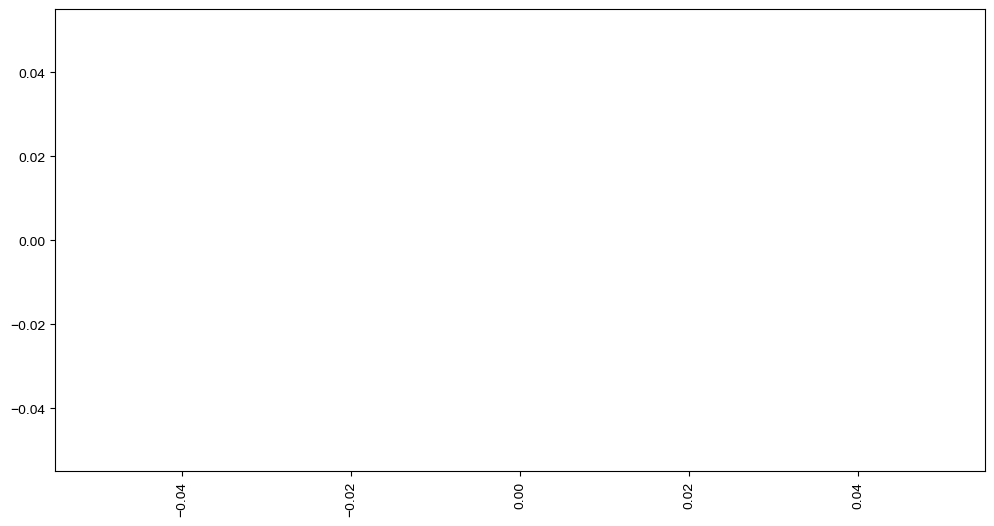

In [6]:
"""
Jobinja Scraper Advanced Usage Example
This script demonstrates advanced usage of the Jobinja scraper including data analysis and visualization.
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from datetime import datetime
import os

class JobinjaAnalyzer:
    def __init__(self, save_dir):
        self.save_dir = save_dir
        self.scraper = Jobinja()
        self.data = None
        
    def run_full_analysis(self, max_pages=None):
        """Run a complete analysis of job postings"""
        # 1. Collect Data
        self.collect_data(max_pages)
        
        # 2. Analyze Data
        self.analyze_job_market()
        
        # 3. Create Visualizations
        self.create_visualizations()
        
        # 4. Generate Reports
        self.generate_reports()
        
    def collect_data(self, max_pages=None):
        """Collect job posting data"""
        print("Collecting job posting data...")
        self.scraper.scrape_jobs(max_pages=max_pages)
        self.data = pd.DataFrame(self.scraper.all_jobs_data)
        
    def analyze_job_market(self):
        """Perform detailed job market analysis"""
        if self.data is None:
            raise ValueError("No data available. Run collect_data first.")
            
        # Create analysis directory
        analysis_dir = os.path.join(self.save_dir, 'analysis')
        os.makedirs(analysis_dir, exist_ok=True)
        
        # Basic statistics
        stats = {
            'total_jobs': len(self.data),
            'unique_companies': self.data['company_name'].nunique(),
            'unique_categories': self.data['job_category'].nunique(),
            'unique_locations': self.data['job_location'].nunique()
        }
        
        # Salary analysis (if available)
        if 'salary' in self.data.columns:
            salary_stats = self.analyze_salaries()
            stats.update(salary_stats)
        
        # Save statistics
        with open(os.path.join(analysis_dir, 'market_analysis.json'), 'w', encoding='utf-8') as f:
            json.dump(stats, f, ensure_ascii=False, indent=4)
            
    def analyze_salaries(self):
        """Analyze salary information"""
        # This is a placeholder for salary analysis
        # You would need to implement proper salary parsing and analysis
        return {}
        
    def create_visualizations(self):
        """Create various visualizations of the job market data"""
        viz_dir = os.path.join(self.save_dir, 'visualizations')
        os.makedirs(viz_dir, exist_ok=True)
        
        # Set style for Persian text
        plt.rcParams['font.family'] = 'Arial'
        
        # 1. Job Categories Distribution
        plt.figure(figsize=(12, 6))
        self.data['job_category'].value_counts().head(10).plot(kind='bar')
        plt.title('Top 10 Job Categories')
        plt.tight_layout()
        plt.savefig(os.path.join(viz_dir, 'job_categories.png'))
        plt.close()
        
        # 2. Companies Distribution
        plt.figure(figsize=(12, 6))
        self.data['company_name'].value_counts().head(10).plot(kind='bar')
        plt.title('Top 10 Companies by Job Postings')
        plt.tight_layout()
        plt.savefig(os.path.join(viz_dir, 'top_companies.png'))
        plt.close()
        
        # 3. Location Distribution
        plt.figure(figsize=(12, 6))
        self.data['job_location'].value_counts().head(10).plot(kind='bar')
        plt.title('Top 10 Job Locations')
        plt.tight_layout()
        plt.savefig(os.path.join(viz_dir, 'job_locations.png'))
        plt.close()
        
    def generate_reports(self):
        """Generate detailed reports from the analyzed data"""
        reports_dir = os.path.join(self.save_dir, 'reports')
        os.makedirs(reports_dir, exist_ok=True)
        
        # Generate summary report
        summary = []
        summary.append("# Jobinja Market Analysis Report")
        summary.append(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        
        # Add basic statistics
        summary.append("## Basic Statistics")
        summary.append(f"Total Jobs Analyzed: {len(self.data)}")
        summary.append(f"Unique Companies: {self.data['company_name'].nunique()}")
        summary.append(f"Job Categories: {self.data['job_category'].nunique()}\n")
        
        # Add top categories
        summary.append("## Top Job Categories")
        top_categories = self.data['job_category'].value_counts().head(10)
        for cat, count in top_categories.items():
            summary.append(f"- {cat}: {count}")
        
        # Save the report
        with open(os.path.join(reports_dir, 'market_analysis_report.md'), 'w', encoding='utf-8') as f:
            f.write('\n'.join(summary))

def main():
    # Create a unique directory for this analysis session
    #timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    save_dir = "JobInja/v4"

    try:
        # Initialize analyzer
        analyzer = JobinjaAnalyzer(save_dir)
        
        # Run complete analysis (limit to 10 pages for testing)
        analyzer.run_full_analysis(max_pages=10)
        
        print(f"\nAnalysis completed. Results saved in: {save_dir}")
        print("\nGenerated files:")
        print(f"- Market analysis: {save_dir}/analysis/market_analysis.json")
        print(f"- Visualizations: {save_dir}/visualizations/")
        print(f"- Reports: {save_dir}/reports/market_analysis_report.md")
        
    except Exception as e:
        print(f"An error occurred during analysis: {e}")
        raise

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("\nAnalysis interrupted by user")
    except Exception as e:
        print(f"\nAn error occurred: {e}")
    finally:
        print("\nScript completed")

In [3]:
import re

def extract_company_data(html):
    companies = []
    
    # Find all company divs
    company_divs = re.findall(r'<div\s+class="u-flex-important u-pL10-sd">(.*?)</div>', html, re.DOTALL)
    
    for company_div in company_divs:
        company = {}
        
        # Extract company name
        company_name_match = re.search(r'<a href="https://jobinja\.ir/companies/([^/]+)/jobs', company_div)
        if company_name_match:
            company['name'] = company_name_match.group(1).replace('-', ' ')
        
        # Extract company logo URL
        logo_url_match = re.search(r'<img class="o-listView__itemIndicatorImage" src="([^"]+)"', company_div)
        if logo_url_match:
            company['logo_url'] = logo_url_match.group(1)
        
        # Extract number of active jobs
        active_jobs_match = re.search(r'<a href="https://jobinja\.ir/companies/[^/]+/jobs" class="color-dark-green">\s*(\d+)\s*شغل فعال\s*</a>', company_div)
        if active_jobs_match:
            company['active_jobs'] = int(active_jobs_match.group(1))
        
        # Extract popularity score
        popularity_match = re.search(r'محبوبیت میان کارجویان.*?(\d+)', company_div)
        if popularity_match:
            company['popularity_score'] = int(popularity_match.group(1))
        
        # Extract job diversity score
        diversity_match = re.search(r'تعدد و تنوع فرصت‌های شغلی.*?(\d+)', company_div)
        if diversity_match:
            company['job_diversity_score'] = int(diversity_match.group(1))
        
        # Extract resume review score
        resume_review_match = re.search(r'بررسی رزومه‌های دریافتی.*?(\d+)', company_div)
        if resume_review_match:
            company['resume_review_score'] = int(resume_review_match.group(1))
        
        # Extract company description
        description_match = re.search(r'<div class="color-gray-05 u-textSmall u-mT20 overflow-ellipsis three-line">\s*(.*?)\s*</div>', company_div, re.DOTALL)
        if description_match:
            company['description'] = description_match.group(1).strip()
        
        companies.append(company)
    
    return companies

# Example usage
html_content = '''
<div class="u-flex-important u-pL10-sd">
    <div class="card-border u-p20 u-p10-sd u-flex flex-column flex-space u-height100 companies-list-card-width">
        <div>
            <div class="u-flex u-mB20">
                <div>
                    <a href="https://jobinja.ir/companies/iranicard" class="u-mB30">
                        <img class="o-listView__itemIndicatorImage" src="https://example.com/iranicard-logo.png" alt="ایرانیکارت">
                    </a>
                </div>
                <div class="u-mR20 u-text-0">
                    <a href="https://jobinja.ir/companies/iranicard" class="u-bold color-gray-07 u-mB1 overflow-ellipsis-1 companies-items-width u-textBase">
                        ایرانیکارت
                    </a>
                    <div class="color-gray-05 u-textSmall overflow-ellipsis-1 companies-items-width">
                        کامپیوتر، فناوری اطلاعات و اینترنت
                    </div>
                </div>
            </div>
            <div class="color-gray-05 u-textSmall u-mT20 overflow-ellipsis three-line">
                ایرانیکارت گروهی جوان اما با تجربه است که سال&zwnj;ها در امور مالی بین المللی به صدها شرکت و هزاران شخص کمک رسانده و می&zwnj;رساند.
            </div>
        </div>
        <div>
            <hr class="u-mT20 u-mB20 u-width100">
            <div class="color-gray-07 u-textSmall">
                <div class="u-flex u-mB10">
                    <div class="u-bold-700 bg-light-green color-dark-green u-pR5 u-pL5 border-radius-2">
                        ۹
                    </div>
                    <div class="u-mR10">محبوبیت میان کارجویان</div>
                </div>
                <div class="u-flex u-mB10">
                    <div class="u-bold-700 bg-light-green color-dark-green u-pR5 u-pL5 border-radius-2">
                        ۶
                    </div>
                    <div class="u-mR10">تعدد و تنوع فرصت‌های شغلی</div>
                </div>
                <div class="u-flex">
                    <div class="u-bold-700 bg-light-green color-dark-green u-pR5 u-pL5 border-radius-2">
                        ۱۰
                    </div>
                    <div class="u-mR10">بررسی رزومه‌های دریافتی</div>
                </div>
            </div>
            <hr class="u-mT20 u-mB20 u-width100">
            <div class="u-flex flex-space u-textSmall">
                <div class="bg-light-green color-dark-green u-pR10 u-pL10 border-radius-2">
                    <a href="https://jobinja.ir/companies/iranicard/jobs" class="color-dark-green">
                        ۱۹
                        شغل فعال
                    </a>
                </div>
                <div class="u-bold u-flex">
                    <a href="https://jobinja.ir/companies/iranicard" class="u-flex align-items-center">
                        صفحه شرکت
                        <div class="chevron-left-blue"></div>
                    </a>
                </div>
            </div>
        </div>
    </div>
</div>
    '''

companies_data = extract_company_data(html_content)
for company in companies_data:
    print(company)

{'logo_url': 'https://example.com/iranicard-logo.png'}


In [7]:
import requests
from bs4 import BeautifulSoup
import json
from typing import Dict, List, Optional
from dataclasses import dataclass
from datetime import datetime
import re

@dataclass
class JobDetails:
    title: str
    category: str
    location: Dict[str, str]
    employment_type: str
    experience_required: str
    salary: str
    required_skills: List[str]
    gender: str
    military_service: str
    minimum_degree: str
    description: str
    responsibilities: List[str]
    requirements: List[str]
    benefits: List[str]
    posted_date: str

@dataclass
class CompanyDetails:
    name: str
    english_name: str
    website: str
    industry_type: str
    company_size: str
    establishment_year: str
    description: str
    logo_url: str

class JobinjaScraper:
    def __init__(self):
        self.base_url = "https://jobinja.ir"
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }

    def _make_request(self, url: str) -> Optional[BeautifulSoup]:
        """Make HTTP request and return BeautifulSoup object"""
        try:
            response = requests.get(url, headers=self.headers)
            response.raise_for_status()
            return BeautifulSoup(response.text, 'html.parser')
        except requests.RequestException as e:
            print(f"Error making request to {url}: {e}")
            return None

    def extract_job_details(self, job_url: str) -> Optional[JobDetails]:
        """Extract details for a specific job posting"""
        soup = self._make_request(job_url)
        if not soup:
            return None

        try:
            # Extract basic info
            info_boxes = soup.find_all('li', class_='c-infoBox__item')
            job_info = {}
            
            for box in info_boxes:
                title = box.find('h4', class_='c-infoBox__itemTitle')
                value = box.find('span', class_='black')
                if title and value:
                    job_info[title.text.strip()] = value.text.strip()

            # Extract job description
            description_div = soup.find('div', class_='o-box__text s-jobDesc')
            description = description_div.text.strip() if description_div else ""

            # Parse responsibilities, requirements and benefits from description
            responsibilities = []
            requirements = []
            benefits = []

            # Extract title from page
            title_element = soup.find('h1')
            title = title_element.text.strip() if title_element else ""

            # Get posting date from meta tags or other sources
            date_element = soup.find('meta', {'property': 'article:published_time'})
            posted_date = date_element['content'] if date_element else datetime.now().strftime('%Y-%m-%d')

            # Create JobDetails object
            return JobDetails(
                title=title,
                category=job_info.get('دسته‌بندی شغلی', ''),
                location={
                    'province': job_info.get('موقعیت مکانی', '').split('،')[0].strip(),
                    'city': job_info.get('موقعیت مکانی', '').split('،')[-1].strip()
                },
                employment_type=job_info.get('نوع همکاری', ''),
                experience_required=job_info.get('حداقل سابقه کار', ''),
                salary=job_info.get('حقوق', ''),
                required_skills=job_info.get('مهارت‌های مورد نیاز', '').split('،'),
                gender=job_info.get('جنسیت', ''),
                military_service=job_info.get('وضعیت نظام وظیفه', ''),
                minimum_degree=job_info.get('حداقل مدرک تحصیلی', ''),
                description=description,
                responsibilities=responsibilities,
                requirements=requirements,
                benefits=benefits,
                posted_date=posted_date
            )

        except Exception as e:
            print(f"Error extracting job details from {job_url}: {e}")
            return None

    def extract_company_details(self, company_url: str) -> Optional[CompanyDetails]:
        """Extract details for a specific company"""
        soup = self._make_request(company_url)
        if not soup:
            return None

        try:
            # Find company header section
            header = soup.find('div', class_='c-companyHeader')
            
            # Extract company information
            name_element = header.find('h2', class_='c-companyHeader__name')
            company_name = name_element.text.split('|')[0].strip() if name_element else ""
            english_name = name_element.text.split('|')[1].strip() if name_element and '|' in name_element.text else ""

            # Find meta information
            meta_items = header.find_all('span', class_='c-companyHeader__metaItem')
            
            company_info = {}
            for item in meta_items:
                text = item.text.strip()
                if 'تاسیس در' in text:
                    company_info['establishment_year'] = text.replace('تاسیس در', '').strip()
                elif 'نفر' in text:
                    company_info['company_size'] = text
                else:
                    link = item.find('a')
                    if link:
                        if 'http' in link['href']:
                            company_info['website'] = link.text.strip()
                        else:
                            company_info['industry_type'] = link.text.strip()

            # Get company description
            description_element = soup.find('div', class_='c-companyHeader__description')
            description = description_element.text.strip() if description_element else ""

            # Get logo URL
            logo_element = soup.find('img', class_='c-companyHeader__logoImage')
            logo_url = logo_element['src'] if logo_element else ""

            return CompanyDetails(
                name=company_name,
                english_name=english_name,
                website=company_info.get('website', ''),
                industry_type=company_info.get('industry_type', ''),
                company_size=company_info.get('company_size', ''),
                establishment_year=company_info.get('establishment_year', ''),
                description=description,
                logo_url=logo_url
            )

        except Exception as e:
            print(f"Error extracting company details from {company_url}: {e}")
            return None

    def get_all_jobs(self, max_pages: int = 1) -> List[Dict]:
        """Get all jobs from multiple pages"""
        all_jobs = []
        
        for page in range(1, max_pages + 1):
            url = f"{self.base_url}/jobs?page={page}"
            soup = self._make_request(url)
            if not soup:
                continue

            try:
                job_items = soup.find_all('li', class_='c-jobListView__item')
                
                for job_item in job_items:
                    try:
                        # Extract job link
                        job_link = job_item.find('a', class_='c-jobListView__titleLink')
                        if not job_link:
                            continue

                        job_url = job_link['href']
                        
                        # Extract basic job information from the list
                        title = job_link.text.strip()
                        company_element = job_item.find('li', class_='c-jobListView__metaItem')
                        company_name = company_element.text.strip() if company_element else ""
                        
                        # Get detailed job information
                        job_details = self.extract_job_details(job_url)
                        
                        if job_details:
                            all_jobs.append({
                                'title': title,
                                'company_name': company_name,
                                'job_url': job_url,
                                'details': job_details
                            })
                            
                    except Exception as e:
                        print(f"Error processing job item: {e}")
                        continue

            except Exception as e:
                print(f"Error processing page {page}: {e}")
                continue

        return all_jobs

    def search_jobs(self, keyword: str, location: str = None) -> List[Dict]:
        """Search for jobs with specific keyword and location"""
        url = f"{self.base_url}/jobs/search?keywords={keyword}"
        if location:
            url += f"&location={location}"
            
        soup = self._make_request(url)
        if not soup:
            return []

        jobs = []
        try:
            job_items = soup.find_all('li', class_='c-jobListView__item')
            
            for job_item in job_items:
                try:
                    job_link = job_item.find('a', class_='c-jobListView__titleLink')
                    if not job_link:
                        continue

                    job_url = job_link['href']
                    title = job_link.text.strip()
                    
                    # Get company name
                    company_element = job_item.find('li', class_='c-jobListView__metaItem')
                    company_name = company_element.text.strip() if company_element else ""
                    
                    # Get job details
                    job_details = self.extract_job_details(job_url)
                    
                    if job_details:
                        jobs.append({
                            'title': title,
                            'company_name': company_name,
                            'job_url': job_url,
                            'details': job_details
                        })
                        
                except Exception as e:
                    print(f"Error processing search result: {e}")
                    continue

        except Exception as e:
            print(f"Error searching jobs: {e}")
            
        return jobs

def main():
    # Example usage
    scraper = JobinjaScraper()
    
    # Get company details
    company_url = "https://jobinja.ir/companies/carpars"
    company_details = scraper.extract_company_details(company_url)
    print("Company Details:", company_details)
    
    # Get specific job details
    job_url = "https://jobinja.ir/companies/carpars/jobs/"
    job_details = scraper.extract_job_details(job_url)
    print("Job Details:", job_details)
    
    # Get all jobs from first page
    all_jobs = scraper.get_all_jobs(max_pages=1)
    print(f"Found {len(all_jobs)} jobs")
    
    # Search for specific jobs
    python_jobs = scraper.search_jobs(keyword="python", location="tehran")
    print(f"Found {len(python_jobs)} Python jobs in Tehran")

if __name__ == "__main__":
    main()

Error extracting company details from https://jobinja.ir/companies/asa-1/jobs/Ajcs/%D8%A7%D8%B3%D8%AA%D8%AE%D8%AF%D8%A7%D9%85-senior-net-developer-%D8%AF%D8%B1-%D9%88%DB%8C%D8%B3%D8%AA%D8%A7-%D8%B3%D8%A7%D9%85%D8%A7%D9%86%D9%87-%D8%A2%D8%B3%D8%A7: 'NoneType' object has no attribute 'find'
Company Details: None
Job Details: JobDetails(title='', category='', location={'province': '', 'city': ''}, employment_type='', experience_required='', salary='', required_skills=[''], gender='', military_service='', minimum_degree='', description='', responsibilities=[], requirements=[], benefits=[], posted_date='2024-11-07')
Found 0 jobs
Found 0 Python jobs in Tehran


In [8]:
import requests
import json

def get_json_data():
    # API URL
    url = 'https://jobinja.ir/companies/carpars'
    
    try:
        # Make request
        response = requests.get(url)
        
        # Check if request was successful
        if response.status_code == 200:
            # Get JSON data
            data = response.json()
            
            # Print formatted JSON
            print(json.dumps(data, indent=2))
            
            # Save to file
            with open('user_data.json', 'w') as f:
                json.dump(data, f, indent=2)
                
            print("\nData has been saved to 'user_data.json'")
        else:
            print(f"Error: {response.status_code}")
            
    except requests.RequestException as e:
        print(f"Error making request: {e}")
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")

if __name__ == "__main__":
    get_json_data()

Error making request: HTTPSConnectionPool(host='jobinja.ir', port=443): Max retries exceeded with url: /companies/carpars (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
